# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.continuous, source=Source.all, past=Past.last_bin, durl=Durl.all, max_distance=2)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 67981 substitutions for model Model(time=Time.continuous, source=Source.all, past=Past.last_bin, durl=Durl.all, max_distance=2)


  0% (    1 of 67981) |           | Elapsed Time: 0:00:03 ETA:  2 days, 20:17:38

  0% (   77 of 67981) |                    | Elapsed Time: 0:00:04 ETA:  0:15:00

  0% (  146 of 67981) |                    | Elapsed Time: 0:00:05 ETA:  0:15:37

  0% (  234 of 67981) |                    | Elapsed Time: 0:00:06 ETA:  0:14:33

  0% (  323 of 67981) |                    | Elapsed Time: 0:00:07 ETA:  0:14:00

  0% (  411 of 67981) |                    | Elapsed Time: 0:00:08 ETA:  0:13:43

  0% (  500 of 67981) |                    | Elapsed Time: 0:00:09 ETA:  0:13:31

  0% (  589 of 67981) |                    | Elapsed Time: 0:00:10 ETA:  0:13:22

  0% (  675 of 67981) |                    | Elapsed Time: 0:00:11 ETA:  0:13:19

  1% (  765 of 67981) |                    | Elapsed Time: 0:00:12 ETA:  0:13:12

  1% (  850 of 67981) |                    | Elapsed Time: 0:00:13 ETA:  0:12:56

  1% (  939 of 67981) |                    | Elapsed Time: 0:00:14 ETA:  0:12:35

  1% ( 1024 of 67981) |                    | Elapsed Time: 0:00:15 ETA:  0:12:37

  1% ( 1112 of 67981) |                    | Elapsed Time: 0:00:16 ETA:  0:12:37

  1% ( 1201 of 67981) |                    | Elapsed Time: 0:00:17 ETA:  0:12:35

  1% ( 1288 of 67981) |                    | Elapsed Time: 0:00:18 ETA:  0:12:36

  2% ( 1378 of 67981) |                    | Elapsed Time: 0:00:19 ETA:  0:12:35

  2% ( 1468 of 67981) |                    | Elapsed Time: 0:00:20 ETA:  0:12:30

  2% ( 1556 of 67981) |                    | Elapsed Time: 0:00:21 ETA:  0:12:31

  2% ( 1645 of 67981) |                    | Elapsed Time: 0:00:22 ETA:  0:12:32

  2% ( 1700 of 67981) |                    | Elapsed Time: 0:00:23 ETA:  0:12:32

  2% ( 1793 of 67981) |                    | Elapsed Time: 0:00:24 ETA:  0:12:22

  2% ( 1889 of 67981) |                    | Elapsed Time: 0:00:25 ETA:  0:12:13

  2% ( 1978 of 67981) |                    | Elapsed Time: 0:00:26 ETA:  0:12:13

  3% ( 2068 of 67981) |                    | Elapsed Time: 0:00:27 ETA:  0:12:09

  3% ( 2158 of 67981) |                    | Elapsed Time: 0:00:28 ETA:  0:12:07

  3% ( 2249 of 67981) |                    | Elapsed Time: 0:00:29 ETA:  0:12:04

  3% ( 2308 of 67981) |                    | Elapsed Time: 0:00:30 ETA:  0:12:32

  3% ( 2399 of 67981) |                    | Elapsed Time: 0:00:31 ETA:  0:12:29

  3% ( 2486 of 67981) |                    | Elapsed Time: 0:00:32 ETA:  0:12:30

  3% ( 2550 of 67981) |                    | Elapsed Time: 0:00:33 ETA:  0:12:36

  3% ( 2638 of 67981) |                    | Elapsed Time: 0:00:34 ETA:  0:12:44

  4% ( 2728 of 67981) |                    | Elapsed Time: 0:00:35 ETA:  0:12:41

  4% ( 2815 of 67981) |                    | Elapsed Time: 0:00:36 ETA:  0:12:43

  4% ( 2891 of 67981) |                    | Elapsed Time: 0:00:37 ETA:  0:12:58

  4% ( 2964 of 67981) |                    | Elapsed Time: 0:00:38 ETA:  0:13:18

  4% ( 3054 of 67981) |                    | Elapsed Time: 0:00:39 ETA:  0:12:42

  4% ( 3149 of 67981) |                    | Elapsed Time: 0:00:40 ETA:  0:12:36

  4% ( 3230 of 67981) |                    | Elapsed Time: 0:00:41 ETA:  0:12:41

  4% ( 3315 of 67981) |                    | Elapsed Time: 0:00:42 ETA:  0:12:41

  5% ( 3400 of 67981) |#                   | Elapsed Time: 0:00:43 ETA:  0:12:44

  5% ( 3484 of 67981) |#                   | Elapsed Time: 0:00:44 ETA:  0:12:50

  5% ( 3566 of 67981) |#                   | Elapsed Time: 0:00:45 ETA:  0:12:54

  5% ( 3652 of 67981) |#                   | Elapsed Time: 0:00:46 ETA:  0:12:42

  5% ( 3742 of 67981) |#                   | Elapsed Time: 0:00:47 ETA:  0:12:23

  5% ( 3830 of 67981) |#                   | Elapsed Time: 0:00:48 ETA:  0:12:25

  5% ( 3917 of 67981) |#                   | Elapsed Time: 0:00:49 ETA:  0:12:33

  5% ( 4006 of 67981) |#                   | Elapsed Time: 0:00:50 ETA:  0:12:24

  6% ( 4093 of 67981) |#                   | Elapsed Time: 0:00:51 ETA:  0:12:20

  6% ( 4178 of 67981) |#                   | Elapsed Time: 0:00:52 ETA:  0:12:19

  6% ( 4249 of 67981) |#                   | Elapsed Time: 0:00:53 ETA:  0:12:22

  6% ( 4333 of 67981) |#                   | Elapsed Time: 0:00:54 ETA:  0:12:20

  6% ( 4414 of 67981) |#                   | Elapsed Time: 0:00:55 ETA:  0:12:23

  6% ( 4497 of 67981) |#                   | Elapsed Time: 0:00:56 ETA:  0:12:30

  6% ( 4580 of 67981) |#                   | Elapsed Time: 0:00:57 ETA:  0:12:35

  6% ( 4657 of 67981) |#                   | Elapsed Time: 0:00:58 ETA:  0:12:51

  6% ( 4698 of 67981) |#                   | Elapsed Time: 0:00:59 ETA:  0:13:49

  7% ( 4761 of 67981) |#                   | Elapsed Time: 0:01:00 ETA:  0:14:21

  7% ( 4832 of 67981) |#                   | Elapsed Time: 0:01:01 ETA:  0:14:41

  7% ( 4899 of 67981) |#                   | Elapsed Time: 0:01:02 ETA:  0:14:56

  7% ( 4963 of 67981) |#                   | Elapsed Time: 0:01:03 ETA:  0:15:25

  7% ( 5042 of 67981) |#                   | Elapsed Time: 0:01:04 ETA:  0:15:28

  7% ( 5099 of 67981) |#                   | Elapsed Time: 0:01:04 ETA:  0:15:36

  7% ( 5180 of 67981) |#                   | Elapsed Time: 0:01:06 ETA:  0:15:38

  7% ( 5260 of 67981) |#                   | Elapsed Time: 0:01:07 ETA:  0:15:23

  7% ( 5336 of 67981) |#                   | Elapsed Time: 0:01:08 ETA:  0:14:26

  7% ( 5414 of 67981) |#                   | Elapsed Time: 0:01:09 ETA:  0:14:03

  8% ( 5491 of 67981) |#                   | Elapsed Time: 0:01:10 ETA:  0:13:54

  8% ( 5569 of 67981) |#                   | Elapsed Time: 0:01:11 ETA:  0:13:38

  8% ( 5646 of 67981) |#                   | Elapsed Time: 0:01:12 ETA:  0:13:20

  8% ( 5719 of 67981) |#                   | Elapsed Time: 0:01:13 ETA:  0:13:27

  8% ( 5795 of 67981) |#                   | Elapsed Time: 0:01:14 ETA:  0:13:31

  8% ( 5869 of 67981) |#                   | Elapsed Time: 0:01:15 ETA:  0:13:39

  8% ( 5949 of 67981) |#                   | Elapsed Time: 0:01:16 ETA:  0:13:41

  8% ( 6029 of 67981) |#                   | Elapsed Time: 0:01:17 ETA:  0:13:37

  8% ( 6100 of 67981) |#                   | Elapsed Time: 0:01:18 ETA:  0:13:43

  9% ( 6177 of 67981) |#                   | Elapsed Time: 0:01:19 ETA:  0:13:44

  9% ( 6257 of 67981) |#                   | Elapsed Time: 0:01:20 ETA:  0:13:39

  9% ( 6334 of 67981) |#                   | Elapsed Time: 0:01:21 ETA:  0:13:31

  9% ( 6411 of 67981) |#                   | Elapsed Time: 0:01:22 ETA:  0:13:28

  9% ( 6491 of 67981) |#                   | Elapsed Time: 0:01:23 ETA:  0:13:19

  9% ( 6571 of 67981) |#                   | Elapsed Time: 0:01:24 ETA:  0:13:15

  9% ( 6646 of 67981) |#                   | Elapsed Time: 0:01:25 ETA:  0:13:19

  9% ( 6720 of 67981) |#                   | Elapsed Time: 0:01:26 ETA:  0:13:26

 10% ( 6799 of 67981) |##                  | Elapsed Time: 0:01:27 ETA:  0:13:30

 10% ( 6884 of 67981) |##                  | Elapsed Time: 0:01:28 ETA:  0:13:21

 10% ( 6968 of 67981) |##                  | Elapsed Time: 0:01:29 ETA:  0:13:10

 10% ( 7056 of 67981) |##                  | Elapsed Time: 0:01:30 ETA:  0:12:55

 10% ( 7156 of 67981) |##                  | Elapsed Time: 0:01:31 ETA:  0:12:29

 10% ( 7239 of 67981) |##                  | Elapsed Time: 0:01:32 ETA:  0:12:24

 10% ( 7308 of 67981) |##                  | Elapsed Time: 0:01:33 ETA:  0:12:29

 10% ( 7367 of 67981) |##                  | Elapsed Time: 0:01:34 ETA:  0:12:47

 10% ( 7427 of 67981) |##                  | Elapsed Time: 0:01:35 ETA:  0:12:55

 11% ( 7487 of 67981) |##                  | Elapsed Time: 0:01:36 ETA:  0:13:19

 11% ( 7547 of 67981) |##                  | Elapsed Time: 0:01:37 ETA:  0:13:53

 11% ( 7607 of 67981) |##                  | Elapsed Time: 0:01:38 ETA:  0:14:27

 11% ( 7648 of 67981) |##                  | Elapsed Time: 0:01:39 ETA:  0:17:13

 11% ( 7707 of 67981) |##                  | Elapsed Time: 0:01:40 ETA:  0:18:11

 11% ( 7764 of 67981) |##                  | Elapsed Time: 0:01:41 ETA:  0:18:42

 11% ( 7828 of 67981) |##                  | Elapsed Time: 0:01:42 ETA:  0:18:27

 11% ( 7892 of 67981) |##                  | Elapsed Time: 0:01:43 ETA:  0:18:16

 11% ( 7967 of 67981) |##                  | Elapsed Time: 0:01:44 ETA:  0:17:38

 11% ( 8033 of 67981) |##                  | Elapsed Time: 0:01:45 ETA:  0:17:21

 11% ( 8108 of 67981) |##                  | Elapsed Time: 0:01:46 ETA:  0:16:45

 12% ( 8198 of 67981) |##                  | Elapsed Time: 0:01:47 ETA:  0:14:51

 12% ( 8282 of 67981) |##                  | Elapsed Time: 0:01:48 ETA:  0:14:24

 12% ( 8366 of 67981) |##                  | Elapsed Time: 0:01:49 ETA:  0:13:45

 12% ( 8427 of 67981) |##                  | Elapsed Time: 0:01:50 ETA:  0:13:39

 12% ( 8498 of 67981) |##                  | Elapsed Time: 0:01:51 ETA:  0:13:20

 12% ( 8587 of 67981) |##                  | Elapsed Time: 0:01:52 ETA:  0:12:46

 12% ( 8680 of 67981) |##                  | Elapsed Time: 0:01:53 ETA:  0:12:22

 12% ( 8749 of 67981) |##                  | Elapsed Time: 0:01:54 ETA:  0:12:18

 12% ( 8809 of 67981) |##                  | Elapsed Time: 0:01:55 ETA:  0:12:35

 13% ( 8878 of 67981) |##                  | Elapsed Time: 0:01:56 ETA:  0:13:01

 13% ( 8953 of 67981) |##                  | Elapsed Time: 0:01:57 ETA:  0:13:12

 13% ( 9025 of 67981) |##                  | Elapsed Time: 0:01:58 ETA:  0:13:27

 13% ( 9098 of 67981) |##                  | Elapsed Time: 0:01:59 ETA:  0:13:08

 13% ( 9178 of 67981) |##                  | Elapsed Time: 0:02:00 ETA:  0:13:04

 13% ( 9252 of 67981) |##                  | Elapsed Time: 0:02:01 ETA:  0:13:23

 13% ( 9327 of 67981) |##                  | Elapsed Time: 0:02:02 ETA:  0:13:48

 13% ( 9348 of 67981) |##                  | Elapsed Time: 0:02:02 ETA:  0:13:40

 13% ( 9433 of 67981) |##                  | Elapsed Time: 0:02:03 ETA:  0:13:03

 13% ( 9516 of 67981) |##                  | Elapsed Time: 0:02:04 ETA:  0:12:41

 14% ( 9595 of 67981) |##                  | Elapsed Time: 0:02:05 ETA:  0:12:34

 14% ( 9675 of 67981) |##                  | Elapsed Time: 0:02:06 ETA:  0:12:23

 14% ( 9757 of 67981) |##                  | Elapsed Time: 0:02:07 ETA:  0:12:10

 14% ( 9841 of 67981) |##                  | Elapsed Time: 0:02:08 ETA:  0:12:03

 14% ( 9922 of 67981) |##                  | Elapsed Time: 0:02:09 ETA:  0:11:53

 14% (10006 of 67981) |##                  | Elapsed Time: 0:02:10 ETA:  0:11:41

 14% (10088 of 67981) |##                  | Elapsed Time: 0:02:11 ETA:  0:11:39

 14% (10165 of 67981) |##                  | Elapsed Time: 0:02:12 ETA:  0:11:47

 15% (10198 of 67981) |###                 | Elapsed Time: 0:02:13 ETA:  0:11:52

 15% (10278 of 67981) |###                 | Elapsed Time: 0:02:14 ETA:  0:11:50

 15% (10356 of 67981) |###                 | Elapsed Time: 0:02:15 ETA:  0:11:51

 15% (10435 of 67981) |###                 | Elapsed Time: 0:02:16 ETA:  0:11:54

 15% (10516 of 67981) |###                 | Elapsed Time: 0:02:17 ETA:  0:11:57

 15% (10600 of 67981) |###                 | Elapsed Time: 0:02:18 ETA:  0:11:53

 15% (10686 of 67981) |###                 | Elapsed Time: 0:02:19 ETA:  0:11:49

 15% (10768 of 67981) |###                 | Elapsed Time: 0:02:20 ETA:  0:11:49

 15% (10846 of 67981) |###                 | Elapsed Time: 0:02:21 ETA:  0:11:45

 16% (10929 of 67981) |###                 | Elapsed Time: 0:02:22 ETA:  0:11:38

 16% (11012 of 67981) |###                 | Elapsed Time: 0:02:23 ETA:  0:11:34

 16% (11047 of 67981) |###                 | Elapsed Time: 0:02:23 ETA:  0:11:27

 16% (11131 of 67981) |###                 | Elapsed Time: 0:02:24 ETA:  0:11:19

 16% (11215 of 67981) |###                 | Elapsed Time: 0:02:25 ETA:  0:11:15

 16% (11298 of 67981) |###                 | Elapsed Time: 0:02:26 ETA:  0:11:15

 16% (11359 of 67981) |###                 | Elapsed Time: 0:02:28 ETA:  0:12:13

 16% (11438 of 67981) |###                 | Elapsed Time: 0:02:29 ETA:  0:12:16

 16% (11523 of 67981) |###                 | Elapsed Time: 0:02:30 ETA:  0:12:07

 17% (11604 of 67981) |###                 | Elapsed Time: 0:02:31 ETA:  0:12:08

 17% (11685 of 67981) |###                 | Elapsed Time: 0:02:32 ETA:  0:12:10

 17% (11765 of 67981) |###                 | Elapsed Time: 0:02:33 ETA:  0:12:11

 17% (11848 of 67981) |###                 | Elapsed Time: 0:02:34 ETA:  0:12:11

 17% (11897 of 67981) |###                 | Elapsed Time: 0:02:34 ETA:  0:12:13

 17% (11978 of 67981) |###                 | Elapsed Time: 0:02:35 ETA:  0:12:15

 17% (12067 of 67981) |###                 | Elapsed Time: 0:02:36 ETA:  0:11:12

 17% (12152 of 67981) |###                 | Elapsed Time: 0:02:37 ETA:  0:11:03

 17% (12229 of 67981) |###                 | Elapsed Time: 0:02:38 ETA:  0:11:11

 18% (12305 of 67981) |###                 | Elapsed Time: 0:02:39 ETA:  0:11:15

 18% (12387 of 67981) |###                 | Elapsed Time: 0:02:40 ETA:  0:11:13

 18% (12471 of 67981) |###                 | Elapsed Time: 0:02:41 ETA:  0:11:08

 18% (12556 of 67981) |###                 | Elapsed Time: 0:02:42 ETA:  0:11:04

 18% (12641 of 67981) |###                 | Elapsed Time: 0:02:43 ETA:  0:11:02

 18% (12728 of 67981) |###                 | Elapsed Time: 0:02:44 ETA:  0:10:54

 18% (12747 of 67981) |###                 | Elapsed Time: 0:02:45 ETA:  0:11:00

 18% (12834 of 67981) |###                 | Elapsed Time: 0:02:46 ETA:  0:10:57

 19% (12921 of 67981) |###                 | Elapsed Time: 0:02:47 ETA:  0:10:44

 19% (13010 of 67981) |###                 | Elapsed Time: 0:02:48 ETA:  0:10:28

 19% (13098 of 67981) |###                 | Elapsed Time: 0:02:49 ETA:  0:10:20

 19% (13185 of 67981) |###                 | Elapsed Time: 0:02:50 ETA:  0:10:17

 19% (13271 of 67981) |###                 | Elapsed Time: 0:02:51 ETA:  0:10:15

 19% (13358 of 67981) |###                 | Elapsed Time: 0:02:52 ETA:  0:10:11

 19% (13446 of 67981) |###                 | Elapsed Time: 0:02:53 ETA:  0:10:09

 19% (13534 of 67981) |###                 | Elapsed Time: 0:02:54 ETA:  0:10:07

 20% (13597 of 67981) |####                | Elapsed Time: 0:02:54 ETA:  0:10:05

 20% (13686 of 67981) |####                | Elapsed Time: 0:02:55 ETA:  0:10:02

 20% (13774 of 67981) |####                | Elapsed Time: 0:02:56 ETA:  0:10:02

 20% (13862 of 67981) |####                | Elapsed Time: 0:02:57 ETA:  0:10:01

 20% (13946 of 67981) |####                | Elapsed Time: 0:02:58 ETA:  0:10:03

 20% (14034 of 67981) |####                | Elapsed Time: 0:02:59 ETA:  0:10:00

 20% (14120 of 67981) |####                | Elapsed Time: 0:03:00 ETA:  0:10:00

 20% (14208 of 67981) |####                | Elapsed Time: 0:03:01 ETA:  0:09:59

 21% (14296 of 67981) |####                | Elapsed Time: 0:03:02 ETA:  0:09:58

 21% (14384 of 67981) |####                | Elapsed Time: 0:03:03 ETA:  0:09:58

 21% (14446 of 67981) |####                | Elapsed Time: 0:03:04 ETA:  0:10:00

 21% (14533 of 67981) |####                | Elapsed Time: 0:03:05 ETA:  0:10:00

 21% (14619 of 67981) |####                | Elapsed Time: 0:03:06 ETA:  0:10:01

 21% (14707 of 67981) |####                | Elapsed Time: 0:03:07 ETA:  0:09:55

 21% (14793 of 67981) |####                | Elapsed Time: 0:03:08 ETA:  0:09:57

 21% (14882 of 67981) |####                | Elapsed Time: 0:03:09 ETA:  0:09:52

 22% (14967 of 67981) |####                | Elapsed Time: 0:03:10 ETA:  0:09:54

 22% (15054 of 67981) |####                | Elapsed Time: 0:03:11 ETA:  0:09:55

 22% (15140 of 67981) |####                | Elapsed Time: 0:03:12 ETA:  0:09:55

 22% (15228 of 67981) |####                | Elapsed Time: 0:03:13 ETA:  0:09:52

 22% (15296 of 67981) |####                | Elapsed Time: 0:03:14 ETA:  0:09:51

 22% (15384 of 67981) |####                | Elapsed Time: 0:03:15 ETA:  0:09:48

 22% (15473 of 67981) |####                | Elapsed Time: 0:03:16 ETA:  0:09:46

 22% (15559 of 67981) |####                | Elapsed Time: 0:03:17 ETA:  0:09:45

 23% (15647 of 67981) |####                | Elapsed Time: 0:03:18 ETA:  0:09:45

 23% (15735 of 67981) |####                | Elapsed Time: 0:03:19 ETA:  0:09:41

 23% (15823 of 67981) |####                | Elapsed Time: 0:03:20 ETA:  0:09:39

 23% (15910 of 67981) |####                | Elapsed Time: 0:03:21 ETA:  0:09:37

 23% (16000 of 67981) |####                | Elapsed Time: 0:03:22 ETA:  0:09:34

 23% (16086 of 67981) |####                | Elapsed Time: 0:03:24 ETA:  0:10:34

 23% (16146 of 67981) |####                | Elapsed Time: 0:03:24 ETA:  0:10:39

 23% (16231 of 67981) |####                | Elapsed Time: 0:03:25 ETA:  0:10:43

 24% (16319 of 67981) |####                | Elapsed Time: 0:03:26 ETA:  0:10:39

 24% (16405 of 67981) |####                | Elapsed Time: 0:03:27 ETA:  0:10:41

 24% (16492 of 67981) |####                | Elapsed Time: 0:03:28 ETA:  0:10:41

 24% (16583 of 67981) |####                | Elapsed Time: 0:03:29 ETA:  0:10:37

 24% (16672 of 67981) |####                | Elapsed Time: 0:03:30 ETA:  0:10:34

 24% (16738 of 67981) |####                | Elapsed Time: 0:03:31 ETA:  0:11:02

 24% (16807 of 67981) |####                | Elapsed Time: 0:03:32 ETA:  0:10:16

 24% (16871 of 67981) |####                | Elapsed Time: 0:03:33 ETA:  0:10:37

 24% (16936 of 67981) |####                | Elapsed Time: 0:03:34 ETA:  0:11:00

 25% (16996 of 67981) |#####               | Elapsed Time: 0:03:35 ETA:  0:11:29

 25% (17059 of 67981) |#####               | Elapsed Time: 0:03:36 ETA:  0:11:59

 25% (17119 of 67981) |#####               | Elapsed Time: 0:03:37 ETA:  0:12:38

 25% (17188 of 67981) |#####               | Elapsed Time: 0:03:38 ETA:  0:13:13

 25% (17263 of 67981) |#####               | Elapsed Time: 0:03:39 ETA:  0:13:35

 25% (17336 of 67981) |#####               | Elapsed Time: 0:03:40 ETA:  0:13:20

 25% (17408 of 67981) |#####               | Elapsed Time: 0:03:41 ETA:  0:13:14

 25% (17480 of 67981) |#####               | Elapsed Time: 0:03:42 ETA:  0:13:00

 25% (17547 of 67981) |#####               | Elapsed Time: 0:03:43 ETA:  0:12:57

 25% (17632 of 67981) |#####               | Elapsed Time: 0:03:45 ETA:  0:12:23

 26% (17715 of 67981) |#####               | Elapsed Time: 0:03:46 ETA:  0:11:53

 26% (17798 of 67981) |#####               | Elapsed Time: 0:03:47 ETA:  0:11:21

 26% (17846 of 67981) |#####               | Elapsed Time: 0:03:47 ETA:  0:11:05

 26% (17929 of 67981) |#####               | Elapsed Time: 0:03:48 ETA:  0:10:55

 26% (18013 of 67981) |#####               | Elapsed Time: 0:03:49 ETA:  0:10:40

 26% (18098 of 67981) |#####               | Elapsed Time: 0:03:50 ETA:  0:10:21

 26% (18183 of 67981) |#####               | Elapsed Time: 0:03:51 ETA:  0:10:04

 26% (18268 of 67981) |#####               | Elapsed Time: 0:03:52 ETA:  0:09:41

 26% (18352 of 67981) |#####               | Elapsed Time: 0:03:53 ETA:  0:09:41

 27% (18435 of 67981) |#####               | Elapsed Time: 0:03:54 ETA:  0:09:40

 27% (18519 of 67981) |#####               | Elapsed Time: 0:03:55 ETA:  0:09:37

 27% (18604 of 67981) |#####               | Elapsed Time: 0:03:56 ETA:  0:09:35

 27% (18695 of 67981) |#####               | Elapsed Time: 0:03:57 ETA:  0:09:27

 27% (18781 of 67981) |#####               | Elapsed Time: 0:03:58 ETA:  0:09:26

 27% (18856 of 67981) |#####               | Elapsed Time: 0:03:59 ETA:  0:09:36

 27% (18933 of 67981) |#####               | Elapsed Time: 0:04:00 ETA:  0:09:46

 27% (19009 of 67981) |#####               | Elapsed Time: 0:04:01 ETA:  0:09:54

 28% (19085 of 67981) |#####               | Elapsed Time: 0:04:02 ETA:  0:10:02

 28% (19165 of 67981) |#####               | Elapsed Time: 0:04:03 ETA:  0:10:07

 28% (19241 of 67981) |#####               | Elapsed Time: 0:04:04 ETA:  0:10:18

 28% (19320 of 67981) |#####               | Elapsed Time: 0:04:05 ETA:  0:10:28

 28% (19408 of 67981) |#####               | Elapsed Time: 0:04:06 ETA:  0:10:15

 28% (19487 of 67981) |#####               | Elapsed Time: 0:04:07 ETA:  0:10:23

 28% (19545 of 67981) |#####               | Elapsed Time: 0:04:08 ETA:  0:10:24

 28% (19617 of 67981) |#####               | Elapsed Time: 0:04:09 ETA:  0:10:28

 28% (19690 of 67981) |#####               | Elapsed Time: 0:04:10 ETA:  0:10:31

 29% (19763 of 67981) |#####               | Elapsed Time: 0:04:11 ETA:  0:10:35

 29% (19860 of 67981) |#####               | Elapsed Time: 0:04:12 ETA:  0:10:12

 29% (19929 of 67981) |#####               | Elapsed Time: 0:04:13 ETA:  0:10:20

 29% (20007 of 67981) |#####               | Elapsed Time: 0:04:14 ETA:  0:10:20

 29% (20088 of 67981) |#####               | Elapsed Time: 0:04:15 ETA:  0:10:28

 29% (20166 of 67981) |#####               | Elapsed Time: 0:04:16 ETA:  0:10:28

 29% (20239 of 67981) |#####               | Elapsed Time: 0:04:17 ETA:  0:10:28

 29% (20307 of 67981) |#####               | Elapsed Time: 0:04:18 ETA:  0:10:32

 30% (20395 of 67981) |######              | Elapsed Time: 0:04:19 ETA:  0:10:12

 30% (20473 of 67981) |######              | Elapsed Time: 0:04:20 ETA:  0:10:05

 30% (20544 of 67981) |######              | Elapsed Time: 0:04:21 ETA:  0:10:37

 30% (20614 of 67981) |######              | Elapsed Time: 0:04:22 ETA:  0:10:35

 30% (20686 of 67981) |######              | Elapsed Time: 0:04:23 ETA:  0:10:43

 30% (20756 of 67981) |######              | Elapsed Time: 0:04:24 ETA:  0:10:57

 30% (20824 of 67981) |######              | Elapsed Time: 0:04:25 ETA:  0:11:10

 30% (20894 of 67981) |######              | Elapsed Time: 0:04:26 ETA:  0:11:13

 30% (20964 of 67981) |######              | Elapsed Time: 0:04:27 ETA:  0:11:09

 30% (21040 of 67981) |######              | Elapsed Time: 0:04:28 ETA:  0:11:26

 31% (21128 of 67981) |######              | Elapsed Time: 0:04:29 ETA:  0:11:11

 31% (21214 of 67981) |######              | Elapsed Time: 0:04:30 ETA:  0:10:48

 31% (21245 of 67981) |######              | Elapsed Time: 0:04:31 ETA:  0:10:34

 31% (21331 of 67981) |######              | Elapsed Time: 0:04:32 ETA:  0:10:13

 31% (21354 of 67981) |######              | Elapsed Time: 0:04:33 ETA:  0:11:32

 31% (21438 of 67981) |######              | Elapsed Time: 0:04:34 ETA:  0:11:06

 31% (21518 of 67981) |######              | Elapsed Time: 0:04:35 ETA:  0:10:50

 31% (21583 of 67981) |######              | Elapsed Time: 0:04:36 ETA:  0:10:57

 31% (21655 of 67981) |######              | Elapsed Time: 0:04:37 ETA:  0:11:02

 31% (21727 of 67981) |######              | Elapsed Time: 0:04:38 ETA:  0:11:27

 32% (21800 of 67981) |######              | Elapsed Time: 0:04:39 ETA:  0:11:48

 32% (21881 of 67981) |######              | Elapsed Time: 0:04:40 ETA:  0:11:39

 32% (21968 of 67981) |######              | Elapsed Time: 0:04:41 ETA:  0:11:37

 32% (22058 of 67981) |######              | Elapsed Time: 0:04:42 ETA:  0:09:53

 32% (22094 of 67981) |######              | Elapsed Time: 0:04:42 ETA:  0:09:53

 32% (22181 of 67981) |######              | Elapsed Time: 0:04:43 ETA:  0:09:43

 32% (22260 of 67981) |######              | Elapsed Time: 0:04:44 ETA:  0:09:23

 32% (22332 of 67981) |######              | Elapsed Time: 0:04:45 ETA:  0:09:22

 32% (22417 of 67981) |######              | Elapsed Time: 0:04:46 ETA:  0:09:05

 33% (22504 of 67981) |######              | Elapsed Time: 0:04:47 ETA:  0:08:46

 33% (22589 of 67981) |######              | Elapsed Time: 0:04:48 ETA:  0:08:41

 33% (22670 of 67981) |######              | Elapsed Time: 0:04:49 ETA:  0:08:46

 33% (22740 of 67981) |######              | Elapsed Time: 0:04:50 ETA:  0:09:09

 33% (22832 of 67981) |######              | Elapsed Time: 0:04:51 ETA:  0:09:01

 33% (22909 of 67981) |######              | Elapsed Time: 0:04:52 ETA:  0:09:12

 33% (22944 of 67981) |######              | Elapsed Time: 0:04:53 ETA:  0:09:10

 33% (23011 of 67981) |######              | Elapsed Time: 0:04:54 ETA:  0:09:16

 33% (23088 of 67981) |######              | Elapsed Time: 0:04:55 ETA:  0:09:25

 34% (23163 of 67981) |######              | Elapsed Time: 0:04:56 ETA:  0:09:40

 34% (23241 of 67981) |######              | Elapsed Time: 0:04:57 ETA:  0:09:48

 34% (23332 of 67981) |######              | Elapsed Time: 0:04:58 ETA:  0:09:33

 34% (23411 of 67981) |######              | Elapsed Time: 0:04:59 ETA:  0:09:22

 34% (23485 of 67981) |######              | Elapsed Time: 0:05:00 ETA:  0:09:44

 34% (23558 of 67981) |######              | Elapsed Time: 0:05:01 ETA:  0:09:48

 34% (23631 of 67981) |######              | Elapsed Time: 0:05:02 ETA:  0:09:53

 34% (23706 of 67981) |######              | Elapsed Time: 0:05:03 ETA:  0:09:43

 35% (23794 of 67981) |#######             | Elapsed Time: 0:05:04 ETA:  0:09:28

 35% (23880 of 67981) |#######             | Elapsed Time: 0:05:05 ETA:  0:09:17

 35% (23954 of 67981) |#######             | Elapsed Time: 0:05:06 ETA:  0:09:39

 35% (24031 of 67981) |#######             | Elapsed Time: 0:05:07 ETA:  0:09:40

 35% (24109 of 67981) |#######             | Elapsed Time: 0:05:08 ETA:  0:09:33

 35% (24187 of 67981) |#######             | Elapsed Time: 0:05:09 ETA:  0:09:24

 35% (24272 of 67981) |#######             | Elapsed Time: 0:05:10 ETA:  0:09:07

 35% (24370 of 67981) |#######             | Elapsed Time: 0:05:11 ETA:  0:08:37

 35% (24463 of 67981) |#######             | Elapsed Time: 0:05:12 ETA:  0:08:25

 36% (24543 of 67981) |#######             | Elapsed Time: 0:05:13 ETA:  0:08:27

 36% (24618 of 67981) |#######             | Elapsed Time: 0:05:14 ETA:  0:08:38

 36% (24644 of 67981) |#######             | Elapsed Time: 0:05:14 ETA:  0:08:34

 36% (24725 of 67981) |#######             | Elapsed Time: 0:05:15 ETA:  0:08:29

 36% (24812 of 67981) |#######             | Elapsed Time: 0:05:16 ETA:  0:08:18

 36% (24894 of 67981) |#######             | Elapsed Time: 0:05:17 ETA:  0:08:13

 36% (24978 of 67981) |#######             | Elapsed Time: 0:05:18 ETA:  0:08:13

 36% (25061 of 67981) |#######             | Elapsed Time: 0:05:19 ETA:  0:08:29

 36% (25148 of 67981) |#######             | Elapsed Time: 0:05:20 ETA:  0:08:36

 37% (25229 of 67981) |#######             | Elapsed Time: 0:05:21 ETA:  0:08:34

 37% (25314 of 67981) |#######             | Elapsed Time: 0:05:22 ETA:  0:08:21

 37% (25407 of 67981) |#######             | Elapsed Time: 0:05:23 ETA:  0:08:03

 37% (25493 of 67981) |#######             | Elapsed Time: 0:05:24 ETA:  0:07:48

 37% (25587 of 67981) |#######             | Elapsed Time: 0:05:25 ETA:  0:07:39

 37% (25676 of 67981) |#######             | Elapsed Time: 0:05:26 ETA:  0:07:30

 37% (25746 of 67981) |#######             | Elapsed Time: 0:05:27 ETA:  0:07:44

 37% (25799 of 67981) |#######             | Elapsed Time: 0:05:28 ETA:  0:08:15

 38% (25870 of 67981) |#######             | Elapsed Time: 0:05:29 ETA:  0:08:33

 38% (25937 of 67981) |#######             | Elapsed Time: 0:05:30 ETA:  0:08:49

 38% (26000 of 67981) |#######             | Elapsed Time: 0:05:31 ETA:  0:09:17

 38% (26060 of 67981) |#######             | Elapsed Time: 0:05:32 ETA:  0:10:01

 38% (26126 of 67981) |#######             | Elapsed Time: 0:05:33 ETA:  0:10:40

 38% (26214 of 67981) |#######             | Elapsed Time: 0:05:34 ETA:  0:10:49

 38% (26303 of 67981) |#######             | Elapsed Time: 0:05:35 ETA:  0:10:48

 38% (26343 of 67981) |#######             | Elapsed Time: 0:05:36 ETA:  0:10:36

 38% (26413 of 67981) |#######             | Elapsed Time: 0:05:37 ETA:  0:10:07

 38% (26484 of 67981) |#######             | Elapsed Time: 0:05:38 ETA:  0:10:06

 39% (26570 of 67981) |#######             | Elapsed Time: 0:05:39 ETA:  0:09:36

 39% (26661 of 67981) |#######             | Elapsed Time: 0:05:40 ETA:  0:08:55

 39% (26751 of 67981) |#######             | Elapsed Time: 0:05:41 ETA:  0:08:17

 39% (26828 of 67981) |#######             | Elapsed Time: 0:05:42 ETA:  0:08:02

 39% (26885 of 67981) |#######             | Elapsed Time: 0:05:43 ETA:  0:08:40

 39% (26947 of 67981) |#######             | Elapsed Time: 0:05:44 ETA:  0:09:15

 39% (27016 of 67981) |#######             | Elapsed Time: 0:05:45 ETA:  0:09:30

 39% (27086 of 67981) |#######             | Elapsed Time: 0:05:46 ETA:  0:09:29

 39% (27175 of 67981) |#######             | Elapsed Time: 0:05:47 ETA:  0:09:05

 40% (27193 of 67981) |########            | Elapsed Time: 0:05:47 ETA:  0:09:17

 40% (27280 of 67981) |########            | Elapsed Time: 0:05:48 ETA:  0:09:22

 40% (27367 of 67981) |########            | Elapsed Time: 0:05:49 ETA:  0:09:25

 40% (27451 of 67981) |########            | Elapsed Time: 0:05:50 ETA:  0:09:14

 40% (27535 of 67981) |########            | Elapsed Time: 0:05:51 ETA:  0:08:35

 40% (27625 of 67981) |########            | Elapsed Time: 0:05:52 ETA:  0:07:58

 40% (27715 of 67981) |########            | Elapsed Time: 0:05:53 ETA:  0:07:32

 40% (27806 of 67981) |########            | Elapsed Time: 0:05:54 ETA:  0:07:07

 40% (27810 of 67981) |########            | Elapsed Time: 0:05:55 ETA:  0:08:56

 41% (27885 of 67981) |########            | Elapsed Time: 0:05:56 ETA:  0:08:57

 41% (27963 of 67981) |########            | Elapsed Time: 0:05:57 ETA:  0:09:09

 41% (28043 of 67981) |########            | Elapsed Time: 0:05:58 ETA:  0:09:39

 41% (28127 of 67981) |########            | Elapsed Time: 0:05:59 ETA:  0:09:37

 41% (28212 of 67981) |########            | Elapsed Time: 0:06:00 ETA:  0:09:45

 41% (28276 of 67981) |########            | Elapsed Time: 0:06:01 ETA:  0:10:29

 41% (28339 of 67981) |########            | Elapsed Time: 0:06:02 ETA:  0:11:18

 41% (28403 of 67981) |########            | Elapsed Time: 0:06:03 ETA:  0:09:25

 41% (28488 of 67981) |########            | Elapsed Time: 0:06:04 ETA:  0:09:09

 42% (28570 of 67981) |########            | Elapsed Time: 0:06:05 ETA:  0:09:02

 42% (28634 of 67981) |########            | Elapsed Time: 0:06:06 ETA:  0:09:20

 42% (28694 of 67981) |########            | Elapsed Time: 0:06:07 ETA:  0:09:38

 42% (28753 of 67981) |########            | Elapsed Time: 0:06:08 ETA:  0:10:17

 42% (28814 of 67981) |########            | Elapsed Time: 0:06:09 ETA:  0:10:55

 42% (28874 of 67981) |########            | Elapsed Time: 0:06:10 ETA:  0:11:00

 42% (28892 of 67981) |########            | Elapsed Time: 0:06:11 ETA:  0:10:58

 42% (28952 of 67981) |########            | Elapsed Time: 0:06:12 ETA:  0:11:05

 42% (29016 of 67981) |########            | Elapsed Time: 0:06:13 ETA:  0:11:46

 42% (29106 of 67981) |########            | Elapsed Time: 0:06:14 ETA:  0:11:28

 42% (29190 of 67981) |########            | Elapsed Time: 0:06:15 ETA:  0:10:47

 43% (29282 of 67981) |########            | Elapsed Time: 0:06:16 ETA:  0:09:51

 43% (29360 of 67981) |########            | Elapsed Time: 0:06:17 ETA:  0:09:18

 43% (29447 of 67981) |########            | Elapsed Time: 0:06:18 ETA:  0:08:38

 43% (29536 of 67981) |########            | Elapsed Time: 0:06:19 ETA:  0:07:58

 43% (29612 of 67981) |########            | Elapsed Time: 0:06:20 ETA:  0:07:54

 43% (29693 of 67981) |########            | Elapsed Time: 0:06:21 ETA:  0:07:29

 43% (29742 of 67981) |########            | Elapsed Time: 0:06:21 ETA:  0:07:06

 43% (29827 of 67981) |########            | Elapsed Time: 0:06:22 ETA:  0:07:11

 44% (29914 of 67981) |########            | Elapsed Time: 0:06:23 ETA:  0:07:07

 44% (29998 of 67981) |########            | Elapsed Time: 0:06:24 ETA:  0:07:15

 44% (30083 of 67981) |########            | Elapsed Time: 0:06:25 ETA:  0:07:06

 44% (30168 of 67981) |########            | Elapsed Time: 0:06:26 ETA:  0:07:08

 44% (30252 of 67981) |########            | Elapsed Time: 0:06:27 ETA:  0:07:13

 44% (30337 of 67981) |########            | Elapsed Time: 0:06:28 ETA:  0:07:02

 44% (30422 of 67981) |########            | Elapsed Time: 0:06:29 ETA:  0:06:57

 44% (30504 of 67981) |########            | Elapsed Time: 0:06:30 ETA:  0:06:58

 44% (30571 of 67981) |########            | Elapsed Time: 0:06:31 ETA:  0:07:16

 45% (30592 of 67981) |#########           | Elapsed Time: 0:06:32 ETA:  0:07:27

 45% (30661 of 67981) |#########           | Elapsed Time: 0:06:33 ETA:  0:07:45

 45% (30752 of 67981) |#########           | Elapsed Time: 0:06:34 ETA:  0:07:36

 45% (30836 of 67981) |#########           | Elapsed Time: 0:06:35 ETA:  0:07:36

 45% (30920 of 67981) |#########           | Elapsed Time: 0:06:36 ETA:  0:07:34

 45% (30987 of 67981) |#########           | Elapsed Time: 0:06:37 ETA:  0:07:57

 45% (31067 of 67981) |#########           | Elapsed Time: 0:06:38 ETA:  0:08:03

 45% (31148 of 67981) |#########           | Elapsed Time: 0:06:39 ETA:  0:08:05

 45% (31228 of 67981) |#########           | Elapsed Time: 0:06:40 ETA:  0:07:46

 46% (31298 of 67981) |#########           | Elapsed Time: 0:06:41 ETA:  0:07:51

 46% (31381 of 67981) |#########           | Elapsed Time: 0:06:42 ETA:  0:07:33

 46% (31442 of 67981) |#########           | Elapsed Time: 0:06:43 ETA:  0:07:54

 46% (31516 of 67981) |#########           | Elapsed Time: 0:06:44 ETA:  0:08:07

 46% (31590 of 67981) |#########           | Elapsed Time: 0:06:45 ETA:  0:08:19

 46% (31664 of 67981) |#########           | Elapsed Time: 0:06:46 ETA:  0:08:09

 46% (31739 of 67981) |#########           | Elapsed Time: 0:06:47 ETA:  0:08:14

 46% (31815 of 67981) |#########           | Elapsed Time: 0:06:48 ETA:  0:08:19

 46% (31944 of 67981) |#########           | Elapsed Time: 0:06:49 ETA:  0:07:16

 47% (32078 of 67981) |#########           | Elapsed Time: 0:06:50 ETA:  0:06:05

 47% (32164 of 67981) |#########           | Elapsed Time: 0:06:51 ETA:  0:06:01

 47% (32213 of 67981) |#########           | Elapsed Time: 0:06:52 ETA:  0:06:26

 47% (32291 of 67981) |#########           | Elapsed Time: 0:06:53 ETA:  0:06:20

 47% (32354 of 67981) |#########           | Elapsed Time: 0:06:54 ETA:  0:06:31

 47% (32432 of 67981) |#########           | Elapsed Time: 0:06:55 ETA:  0:06:26

 47% (32501 of 67981) |#########           | Elapsed Time: 0:06:56 ETA:  0:06:32

 47% (32571 of 67981) |#########           | Elapsed Time: 0:06:57 ETA:  0:06:37

 48% (32640 of 67981) |#########           | Elapsed Time: 0:06:58 ETA:  0:07:46

 48% (32708 of 67981) |#########           | Elapsed Time: 0:06:59 ETA:  0:09:19

 48% (32800 of 67981) |#########           | Elapsed Time: 0:07:00 ETA:  0:09:10

 48% (32892 of 67981) |#########           | Elapsed Time: 0:07:01 ETA:  0:08:07

 48% (32986 of 67981) |#########           | Elapsed Time: 0:07:02 ETA:  0:07:44

 48% (33071 of 67981) |#########           | Elapsed Time: 0:07:03 ETA:  0:07:16

 48% (33141 of 67981) |#########           | Elapsed Time: 0:07:04 ETA:  0:07:18

 48% (33211 of 67981) |#########           | Elapsed Time: 0:07:05 ETA:  0:07:17

 48% (33308 of 67981) |#########           | Elapsed Time: 0:07:06 ETA:  0:06:41

 49% (33412 of 67981) |#########           | Elapsed Time: 0:07:07 ETA:  0:05:56

 49% (33516 of 67981) |#########           | Elapsed Time: 0:07:08 ETA:  0:05:42

 49% (33596 of 67981) |#########           | Elapsed Time: 0:07:09 ETA:  0:05:54

 49% (33701 of 67981) |#########           | Elapsed Time: 0:07:10 ETA:  0:05:41

 49% (33833 of 67981) |#########           | Elapsed Time: 0:07:11 ETA:  0:04:52

 49% (33914 of 67981) |#########           | Elapsed Time: 0:07:12 ETA:  0:04:36

 50% (33991 of 67981) |##########          | Elapsed Time: 0:07:13 ETA:  0:04:33

 50% (34060 of 67981) |##########          | Elapsed Time: 0:07:14 ETA:  0:04:58

 50% (34144 of 67981) |##########          | Elapsed Time: 0:07:15 ETA:  0:05:19

 50% (34230 of 67981) |##########          | Elapsed Time: 0:07:16 ETA:  0:05:38

 50% (34312 of 67981) |##########          | Elapsed Time: 0:07:17 ETA:  0:05:34

 50% (34412 of 67981) |##########          | Elapsed Time: 0:07:18 ETA:  0:05:39

 50% (34498 of 67981) |##########          | Elapsed Time: 0:07:19 ETA:  0:06:32

 50% (34587 of 67981) |##########          | Elapsed Time: 0:07:20 ETA:  0:06:21

 51% (34680 of 67981) |##########          | Elapsed Time: 0:07:21 ETA:  0:05:54

 51% (34771 of 67981) |##########          | Elapsed Time: 0:07:22 ETA:  0:05:47

 51% (34841 of 67981) |##########          | Elapsed Time: 0:07:23 ETA:  0:05:27

 51% (34920 of 67981) |##########          | Elapsed Time: 0:07:24 ETA:  0:05:30

 51% (34981 of 67981) |##########          | Elapsed Time: 0:07:25 ETA:  0:05:55

 51% (35056 of 67981) |##########          | Elapsed Time: 0:07:26 ETA:  0:06:02

 51% (35133 of 67981) |##########          | Elapsed Time: 0:07:27 ETA:  0:06:26

 51% (35206 of 67981) |##########          | Elapsed Time: 0:07:28 ETA:  0:06:41

 51% (35285 of 67981) |##########          | Elapsed Time: 0:07:29 ETA:  0:06:52

 52% (35362 of 67981) |##########          | Elapsed Time: 0:07:30 ETA:  0:07:12

 52% (35442 of 67981) |##########          | Elapsed Time: 0:07:31 ETA:  0:07:26

 52% (35524 of 67981) |##########          | Elapsed Time: 0:07:32 ETA:  0:07:30

 52% (35596 of 67981) |##########          | Elapsed Time: 0:07:34 ETA:  0:09:22

 52% (35691 of 67981) |##########          | Elapsed Time: 0:07:35 ETA:  0:08:49

 52% (35777 of 67981) |##########          | Elapsed Time: 0:07:36 ETA:  0:08:34

 52% (35859 of 67981) |##########          | Elapsed Time: 0:07:37 ETA:  0:08:20

 52% (35933 of 67981) |##########          | Elapsed Time: 0:07:38 ETA:  0:08:27

 52% (36016 of 67981) |##########          | Elapsed Time: 0:07:39 ETA:  0:08:18

 53% (36093 of 67981) |##########          | Elapsed Time: 0:07:40 ETA:  0:08:22

 53% (36174 of 67981) |##########          | Elapsed Time: 0:07:41 ETA:  0:08:21

 53% (36252 of 67981) |##########          | Elapsed Time: 0:07:42 ETA:  0:06:23

 53% (36318 of 67981) |##########          | Elapsed Time: 0:07:43 ETA:  0:06:51

 53% (36388 of 67981) |##########          | Elapsed Time: 0:07:44 ETA:  0:07:01

 53% (36472 of 67981) |##########          | Elapsed Time: 0:07:45 ETA:  0:07:02

 53% (36540 of 67981) |##########          | Elapsed Time: 0:07:46 ETA:  0:06:59

 53% (36621 of 67981) |##########          | Elapsed Time: 0:07:47 ETA:  0:06:48

 53% (36698 of 67981) |##########          | Elapsed Time: 0:07:48 ETA:  0:06:55

 54% (36770 of 67981) |##########          | Elapsed Time: 0:07:49 ETA:  0:07:00

 54% (36840 of 67981) |##########          | Elapsed Time: 0:07:50 ETA:  0:07:14

 54% (36927 of 67981) |##########          | Elapsed Time: 0:07:51 ETA:  0:07:01

 54% (37015 of 67981) |##########          | Elapsed Time: 0:07:52 ETA:  0:06:31

 54% (37103 of 67981) |##########          | Elapsed Time: 0:07:53 ETA:  0:06:08

 54% (37188 of 67981) |##########          | Elapsed Time: 0:07:54 ETA:  0:06:06

 54% (37275 of 67981) |##########          | Elapsed Time: 0:07:55 ETA:  0:06:02

 54% (37359 of 67981) |##########          | Elapsed Time: 0:07:56 ETA:  0:05:57

 55% (37390 of 67981) |###########         | Elapsed Time: 0:07:56 ETA:  0:05:49

 55% (37472 of 67981) |###########         | Elapsed Time: 0:07:57 ETA:  0:05:37

 55% (37571 of 67981) |###########         | Elapsed Time: 0:07:58 ETA:  0:05:03

 55% (37667 of 67981) |###########         | Elapsed Time: 0:07:59 ETA:  0:04:52

 55% (37752 of 67981) |###########         | Elapsed Time: 0:08:00 ETA:  0:04:54

 55% (37800 of 67981) |###########         | Elapsed Time: 0:08:01 ETA:  0:05:37

 55% (37849 of 67981) |###########         | Elapsed Time: 0:08:02 ETA:  0:06:20

 55% (37897 of 67981) |###########         | Elapsed Time: 0:08:03 ETA:  0:07:14

 55% (37977 of 67981) |###########         | Elapsed Time: 0:08:04 ETA:  0:07:19

 55% (38065 of 67981) |###########         | Elapsed Time: 0:08:05 ETA:  0:07:04

 56% (38141 of 67981) |###########         | Elapsed Time: 0:08:06 ETA:  0:07:12

 56% (38208 of 67981) |###########         | Elapsed Time: 0:08:07 ETA:  0:07:58

 56% (38240 of 67981) |###########         | Elapsed Time: 0:08:08 ETA:  0:09:30

 56% (38281 of 67981) |###########         | Elapsed Time: 0:08:09 ETA:  0:10:57

 56% (38327 of 67981) |###########         | Elapsed Time: 0:08:10 ETA:  0:11:02

 56% (38402 of 67981) |###########         | Elapsed Time: 0:08:11 ETA:  0:10:08

 56% (38497 of 67981) |###########         | Elapsed Time: 0:08:12 ETA:  0:08:41

 56% (38593 of 67981) |###########         | Elapsed Time: 0:08:13 ETA:  0:08:13

 56% (38663 of 67981) |###########         | Elapsed Time: 0:08:14 ETA:  0:08:41

 56% (38719 of 67981) |###########         | Elapsed Time: 0:08:15 ETA:  0:09:16

 57% (38777 of 67981) |###########         | Elapsed Time: 0:08:16 ETA:  0:09:31

 57% (38839 of 67981) |###########         | Elapsed Time: 0:08:17 ETA:  0:08:51

 57% (38919 of 67981) |###########         | Elapsed Time: 0:08:18 ETA:  0:07:48

 57% (38997 of 67981) |###########         | Elapsed Time: 0:08:19 ETA:  0:07:00

 57% (39090 of 67981) |###########         | Elapsed Time: 0:08:20 ETA:  0:07:21

 57% (39170 of 67981) |###########         | Elapsed Time: 0:08:21 ETA:  0:07:46

 57% (39248 of 67981) |###########         | Elapsed Time: 0:08:23 ETA:  0:07:33

 57% (39315 of 67981) |###########         | Elapsed Time: 0:08:24 ETA:  0:07:14

 57% (39408 of 67981) |###########         | Elapsed Time: 0:08:25 ETA:  0:06:21

 58% (39505 of 67981) |###########         | Elapsed Time: 0:08:26 ETA:  0:05:33

 58% (39601 of 67981) |###########         | Elapsed Time: 0:08:27 ETA:  0:05:12

 58% (39695 of 67981) |###########         | Elapsed Time: 0:08:28 ETA:  0:04:52

 58% (39786 of 67981) |###########         | Elapsed Time: 0:08:29 ETA:  0:04:37

 58% (39875 of 67981) |###########         | Elapsed Time: 0:08:30 ETA:  0:04:33

 58% (39939 of 67981) |###########         | Elapsed Time: 0:08:30 ETA:  0:04:30

 58% (40031 of 67981) |###########         | Elapsed Time: 0:08:31 ETA:  0:04:15

 59% (40116 of 67981) |###########         | Elapsed Time: 0:08:32 ETA:  0:03:55

 59% (40211 of 67981) |###########         | Elapsed Time: 0:08:33 ETA:  0:03:52

 59% (40307 of 67981) |###########         | Elapsed Time: 0:08:34 ETA:  0:03:52

 59% (40397 of 67981) |###########         | Elapsed Time: 0:08:35 ETA:  0:03:58

 59% (40462 of 67981) |###########         | Elapsed Time: 0:08:36 ETA:  0:04:25

 59% (40561 of 67981) |###########         | Elapsed Time: 0:08:37 ETA:  0:04:17

 59% (40645 of 67981) |###########         | Elapsed Time: 0:08:38 ETA:  0:04:21

 59% (40733 of 67981) |###########         | Elapsed Time: 0:08:39 ETA:  0:04:14

 60% (40789 of 67981) |############        | Elapsed Time: 0:08:40 ETA:  0:04:18

 60% (40879 of 67981) |############        | Elapsed Time: 0:08:41 ETA:  0:04:13

 60% (40954 of 67981) |############        | Elapsed Time: 0:08:42 ETA:  0:04:33

 60% (41011 of 67981) |############        | Elapsed Time: 0:08:43 ETA:  0:05:16

 60% (41095 of 67981) |############        | Elapsed Time: 0:08:44 ETA:  0:05:22

 60% (41175 of 67981) |############        | Elapsed Time: 0:08:45 ETA:  0:05:04

 60% (41265 of 67981) |############        | Elapsed Time: 0:08:46 ETA:  0:05:14

 60% (41329 of 67981) |############        | Elapsed Time: 0:08:47 ETA:  0:05:37

 60% (41403 of 67981) |############        | Elapsed Time: 0:08:48 ETA:  0:05:55

 61% (41493 of 67981) |############        | Elapsed Time: 0:08:49 ETA:  0:05:46

 61% (41578 of 67981) |############        | Elapsed Time: 0:08:50 ETA:  0:05:51

 61% (41639 of 67981) |############        | Elapsed Time: 0:08:51 ETA:  0:05:40

 61% (41723 of 67981) |############        | Elapsed Time: 0:08:52 ETA:  0:05:05

 61% (41781 of 67981) |############        | Elapsed Time: 0:08:53 ETA:  0:05:36

 61% (41838 of 67981) |############        | Elapsed Time: 0:08:54 ETA:  0:06:05

 61% (41900 of 67981) |############        | Elapsed Time: 0:08:55 ETA:  0:06:43

 61% (41994 of 67981) |############        | Elapsed Time: 0:08:56 ETA:  0:06:01

 61% (42078 of 67981) |############        | Elapsed Time: 0:08:57 ETA:  0:05:46

 62% (42152 of 67981) |############        | Elapsed Time: 0:08:58 ETA:  0:06:06

 62% (42238 of 67981) |############        | Elapsed Time: 0:08:59 ETA:  0:06:04

 62% (42323 of 67981) |############        | Elapsed Time: 0:09:00 ETA:  0:06:00

 62% (42407 of 67981) |############        | Elapsed Time: 0:09:01 ETA:  0:05:59

 62% (42489 of 67981) |############        | Elapsed Time: 0:09:02 ETA:  0:05:13

 62% (42560 of 67981) |############        | Elapsed Time: 0:09:03 ETA:  0:04:55

 62% (42635 of 67981) |############        | Elapsed Time: 0:09:04 ETA:  0:04:39

 62% (42709 of 67981) |############        | Elapsed Time: 0:09:05 ETA:  0:05:01

 62% (42790 of 67981) |############        | Elapsed Time: 0:09:06 ETA:  0:05:04

 63% (42870 of 67981) |############        | Elapsed Time: 0:09:07 ETA:  0:04:56

 63% (42954 of 67981) |############        | Elapsed Time: 0:09:08 ETA:  0:04:57

 63% (43041 of 67981) |############        | Elapsed Time: 0:09:09 ETA:  0:04:53

 63% (43126 of 67981) |############        | Elapsed Time: 0:09:10 ETA:  0:04:51

 63% (43211 of 67981) |############        | Elapsed Time: 0:09:11 ETA:  0:05:00

 63% (43295 of 67981) |############        | Elapsed Time: 0:09:12 ETA:  0:04:44

 63% (43338 of 67981) |############        | Elapsed Time: 0:09:12 ETA:  0:04:26

 63% (43422 of 67981) |############        | Elapsed Time: 0:09:13 ETA:  0:04:14

 63% (43489 of 67981) |############        | Elapsed Time: 0:09:14 ETA:  0:04:29

 64% (43563 of 67981) |############        | Elapsed Time: 0:09:15 ETA:  0:04:36

 64% (43623 of 67981) |############        | Elapsed Time: 0:09:16 ETA:  0:05:06

 64% (43694 of 67981) |############        | Elapsed Time: 0:09:17 ETA:  0:05:26

 64% (43773 of 67981) |############        | Elapsed Time: 0:09:18 ETA:  0:05:33

 64% (43853 of 67981) |############        | Elapsed Time: 0:09:19 ETA:  0:05:39

 64% (43925 of 67981) |############        | Elapsed Time: 0:09:20 ETA:  0:05:56

 64% (44007 of 67981) |############        | Elapsed Time: 0:09:21 ETA:  0:06:01

 64% (44063 of 67981) |############        | Elapsed Time: 0:09:22 ETA:  0:06:40

 64% (44118 of 67981) |############        | Elapsed Time: 0:09:23 ETA:  0:06:58

 65% (44188 of 67981) |#############       | Elapsed Time: 0:09:24 ETA:  0:06:56

 65% (44275 of 67981) |#############       | Elapsed Time: 0:09:25 ETA:  0:06:27

 65% (44368 of 67981) |#############       | Elapsed Time: 0:09:26 ETA:  0:06:03

 65% (44460 of 67981) |#############       | Elapsed Time: 0:09:27 ETA:  0:05:44

 65% (44531 of 67981) |#############       | Elapsed Time: 0:09:28 ETA:  0:05:45

 65% (44603 of 67981) |#############       | Elapsed Time: 0:09:29 ETA:  0:05:58

 65% (44681 of 67981) |#############       | Elapsed Time: 0:09:30 ETA:  0:05:23

 65% (44763 of 67981) |#############       | Elapsed Time: 0:09:31 ETA:  0:04:45

 65% (44856 of 67981) |#############       | Elapsed Time: 0:09:32 ETA:  0:04:06

 66% (44949 of 67981) |#############       | Elapsed Time: 0:09:33 ETA:  0:03:54

 66% (45038 of 67981) |#############       | Elapsed Time: 0:09:35 ETA:  0:04:05

 66% (45124 of 67981) |#############       | Elapsed Time: 0:09:36 ETA:  0:04:12

 66% (45209 of 67981) |#############       | Elapsed Time: 0:09:37 ETA:  0:03:54

 66% (45262 of 67981) |#############       | Elapsed Time: 0:09:39 ETA:  0:06:19

 66% (45339 of 67981) |#############       | Elapsed Time: 0:09:40 ETA:  0:06:20

 66% (45407 of 67981) |#############       | Elapsed Time: 0:09:41 ETA:  0:06:41

 66% (45474 of 67981) |#############       | Elapsed Time: 0:09:42 ETA:  0:07:20

 67% (45560 of 67981) |#############       | Elapsed Time: 0:09:43 ETA:  0:07:32

 67% (45636 of 67981) |#############       | Elapsed Time: 0:09:44 ETA:  0:07:48

 67% (45701 of 67981) |#############       | Elapsed Time: 0:09:45 ETA:  0:07:48

 67% (45779 of 67981) |#############       | Elapsed Time: 0:09:46 ETA:  0:08:00

 67% (45888 of 67981) |#############       | Elapsed Time: 0:09:47 ETA:  0:05:06

 67% (45977 of 67981) |#############       | Elapsed Time: 0:09:48 ETA:  0:04:47

 67% (46067 of 67981) |#############       | Elapsed Time: 0:09:49 ETA:  0:04:16

 67% (46139 of 67981) |#############       | Elapsed Time: 0:09:50 ETA:  0:04:09

 67% (46217 of 67981) |#############       | Elapsed Time: 0:09:51 ETA:  0:04:18

 68% (46292 of 67981) |#############       | Elapsed Time: 0:09:52 ETA:  0:04:19

 68% (46359 of 67981) |#############       | Elapsed Time: 0:09:53 ETA:  0:04:15

 68% (46436 of 67981) |#############       | Elapsed Time: 0:09:54 ETA:  0:04:16

 68% (46497 of 67981) |#############       | Elapsed Time: 0:09:55 ETA:  0:04:58

 68% (46579 of 67981) |#############       | Elapsed Time: 0:09:56 ETA:  0:04:54

 68% (46665 of 67981) |#############       | Elapsed Time: 0:09:57 ETA:  0:04:57

 68% (46737 of 67981) |#############       | Elapsed Time: 0:09:58 ETA:  0:05:04

 68% (46829 of 67981) |#############       | Elapsed Time: 0:09:59 ETA:  0:04:37

 69% (46910 of 67981) |#############       | Elapsed Time: 0:10:00 ETA:  0:04:33

 69% (46970 of 67981) |#############       | Elapsed Time: 0:10:01 ETA:  0:04:50

 69% (47035 of 67981) |#############       | Elapsed Time: 0:10:02 ETA:  0:04:52

 69% (47135 of 67981) |#############       | Elapsed Time: 0:10:03 ETA:  0:04:21

 69% (47222 of 67981) |#############       | Elapsed Time: 0:10:04 ETA:  0:03:49

 69% (47300 of 67981) |#############       | Elapsed Time: 0:10:05 ETA:  0:03:53

 69% (47387 of 67981) |#############       | Elapsed Time: 0:10:06 ETA:  0:03:51

 69% (47467 of 67981) |#############       | Elapsed Time: 0:10:07 ETA:  0:03:56

 69% (47546 of 67981) |#############       | Elapsed Time: 0:10:08 ETA:  0:04:10

 70% (47587 of 67981) |##############      | Elapsed Time: 0:10:08 ETA:  0:04:07

 70% (47660 of 67981) |##############      | Elapsed Time: 0:10:09 ETA:  0:03:50

 70% (47751 of 67981) |##############      | Elapsed Time: 0:10:10 ETA:  0:03:19

 70% (47818 of 67981) |##############      | Elapsed Time: 0:10:11 ETA:  0:03:57

 70% (47894 of 67981) |##############      | Elapsed Time: 0:10:12 ETA:  0:04:11

 70% (47983 of 67981) |##############      | Elapsed Time: 0:10:13 ETA:  0:03:55

 70% (48068 of 67981) |##############      | Elapsed Time: 0:10:14 ETA:  0:03:56

 70% (48148 of 67981) |##############      | Elapsed Time: 0:10:15 ETA:  0:03:55

 70% (48231 of 67981) |##############      | Elapsed Time: 0:10:16 ETA:  0:03:49

 71% (48300 of 67981) |##############      | Elapsed Time: 0:10:17 ETA:  0:04:05

 71% (48384 of 67981) |##############      | Elapsed Time: 0:10:18 ETA:  0:03:50

 71% (48437 of 67981) |##############      | Elapsed Time: 0:10:19 ETA:  0:03:59

 71% (48526 of 67981) |##############      | Elapsed Time: 0:10:20 ETA:  0:03:32

 71% (48608 of 67981) |##############      | Elapsed Time: 0:10:21 ETA:  0:03:24

 71% (48694 of 67981) |##############      | Elapsed Time: 0:10:22 ETA:  0:03:27

 71% (48783 of 67981) |##############      | Elapsed Time: 0:10:23 ETA:  0:03:21

 71% (48866 of 67981) |##############      | Elapsed Time: 0:10:24 ETA:  0:03:17

 72% (48955 of 67981) |##############      | Elapsed Time: 0:10:25 ETA:  0:03:09

 72% (49051 of 67981) |##############      | Elapsed Time: 0:10:26 ETA:  0:02:39

 72% (49147 of 67981) |##############      | Elapsed Time: 0:10:27 ETA:  0:02:25

 72% (49241 of 67981) |##############      | Elapsed Time: 0:10:28 ETA:  0:02:16

 72% (49287 of 67981) |##############      | Elapsed Time: 0:10:29 ETA:  0:02:13

 72% (49370 of 67981) |##############      | Elapsed Time: 0:10:30 ETA:  0:02:11

 72% (49455 of 67981) |##############      | Elapsed Time: 0:10:31 ETA:  0:02:11

 72% (49541 of 67981) |##############      | Elapsed Time: 0:10:32 ETA:  0:02:13

 73% (49628 of 67981) |##############      | Elapsed Time: 0:10:33 ETA:  0:02:09

 73% (49713 of 67981) |##############      | Elapsed Time: 0:10:34 ETA:  0:02:12

 73% (49799 of 67981) |##############      | Elapsed Time: 0:10:35 ETA:  0:02:21

 73% (49873 of 67981) |##############      | Elapsed Time: 0:10:36 ETA:  0:02:44

 73% (49948 of 67981) |##############      | Elapsed Time: 0:10:37 ETA:  0:03:04

 73% (50034 of 67981) |##############      | Elapsed Time: 0:10:38 ETA:  0:03:06

 73% (50120 of 67981) |##############      | Elapsed Time: 0:10:39 ETA:  0:03:01

 73% (50136 of 67981) |##############      | Elapsed Time: 0:10:39 ETA:  0:03:05

 73% (50212 of 67981) |##############      | Elapsed Time: 0:10:40 ETA:  0:03:17

 73% (50292 of 67981) |##############      | Elapsed Time: 0:10:41 ETA:  0:03:23

 74% (50404 of 67981) |##############      | Elapsed Time: 0:10:42 ETA:  0:02:49

 74% (50497 of 67981) |##############      | Elapsed Time: 0:10:43 ETA:  0:02:40

 74% (50575 of 67981) |##############      | Elapsed Time: 0:10:44 ETA:  0:02:35

 74% (50663 of 67981) |##############      | Elapsed Time: 0:10:45 ETA:  0:02:19

 74% (50736 of 67981) |##############      | Elapsed Time: 0:10:46 ETA:  0:02:33

 74% (50817 of 67981) |##############      | Elapsed Time: 0:10:47 ETA:  0:02:38

 74% (50906 of 67981) |##############      | Elapsed Time: 0:10:48 ETA:  0:02:29

 75% (50986 of 67981) |###############     | Elapsed Time: 0:10:49 ETA:  0:02:22

 75% (51059 of 67981) |###############     | Elapsed Time: 0:10:50 ETA:  0:03:08

 75% (51146 of 67981) |###############     | Elapsed Time: 0:10:51 ETA:  0:03:15

 75% (51244 of 67981) |###############     | Elapsed Time: 0:10:52 ETA:  0:02:48

 75% (51338 of 67981) |###############     | Elapsed Time: 0:10:53 ETA:  0:02:40

 75% (51424 of 67981) |###############     | Elapsed Time: 0:10:54 ETA:  0:02:24

 75% (51518 of 67981) |###############     | Elapsed Time: 0:10:55 ETA:  0:02:08

 75% (51610 of 67981) |###############     | Elapsed Time: 0:10:56 ETA:  0:02:04

 76% (51678 of 67981) |###############     | Elapsed Time: 0:10:57 ETA:  0:02:15

 76% (51732 of 67981) |###############     | Elapsed Time: 0:10:58 ETA:  0:02:46

 76% (51795 of 67981) |###############     | Elapsed Time: 0:10:59 ETA:  0:02:57

 76% (51836 of 67981) |###############     | Elapsed Time: 0:11:00 ETA:  0:03:07

 76% (51940 of 67981) |###############     | Elapsed Time: 0:11:01 ETA:  0:02:59

 76% (52024 of 67981) |###############     | Elapsed Time: 0:11:02 ETA:  0:03:10

 76% (52101 of 67981) |###############     | Elapsed Time: 0:11:03 ETA:  0:03:21

 76% (52172 of 67981) |###############     | Elapsed Time: 0:11:04 ETA:  0:03:50

 76% (52253 of 67981) |###############     | Elapsed Time: 0:11:05 ETA:  0:04:04

 76% (52335 of 67981) |###############     | Elapsed Time: 0:11:06 ETA:  0:03:43

 77% (52428 of 67981) |###############     | Elapsed Time: 0:11:07 ETA:  0:02:52

 77% (52509 of 67981) |###############     | Elapsed Time: 0:11:08 ETA:  0:02:30

 77% (52589 of 67981) |###############     | Elapsed Time: 0:11:09 ETA:  0:02:28

 77% (52686 of 67981) |###############     | Elapsed Time: 0:11:10 ETA:  0:02:51

 77% (52779 of 67981) |###############     | Elapsed Time: 0:11:11 ETA:  0:02:31

 77% (52851 of 67981) |###############     | Elapsed Time: 0:11:12 ETA:  0:02:28

 77% (52926 of 67981) |###############     | Elapsed Time: 0:11:13 ETA:  0:02:35

 77% (53002 of 67981) |###############     | Elapsed Time: 0:11:14 ETA:  0:02:41

 78% (53079 of 67981) |###############     | Elapsed Time: 0:11:15 ETA:  0:03:00

 78% (53162 of 67981) |###############     | Elapsed Time: 0:11:16 ETA:  0:02:56

 78% (53239 of 67981) |###############     | Elapsed Time: 0:11:17 ETA:  0:02:59

 78% (53320 of 67981) |###############     | Elapsed Time: 0:11:18 ETA:  0:02:59

 78% (53400 of 67981) |###############     | Elapsed Time: 0:11:19 ETA:  0:03:02

 78% (53477 of 67981) |###############     | Elapsed Time: 0:11:20 ETA:  0:03:20

 78% (53536 of 67981) |###############     | Elapsed Time: 0:11:21 ETA:  0:03:11

 78% (53615 of 67981) |###############     | Elapsed Time: 0:11:22 ETA:  0:03:05

 78% (53675 of 67981) |###############     | Elapsed Time: 0:11:23 ETA:  0:03:25

 79% (53758 of 67981) |###############     | Elapsed Time: 0:11:24 ETA:  0:03:16

 79% (53823 of 67981) |###############     | Elapsed Time: 0:11:25 ETA:  0:03:39

 79% (53896 of 67981) |###############     | Elapsed Time: 0:11:26 ETA:  0:03:43

 79% (53963 of 67981) |###############     | Elapsed Time: 0:11:27 ETA:  0:04:02

 79% (54050 of 67981) |###############     | Elapsed Time: 0:11:28 ETA:  0:03:51

 79% (54141 of 67981) |###############     | Elapsed Time: 0:11:29 ETA:  0:03:31

 79% (54217 of 67981) |###############     | Elapsed Time: 0:11:30 ETA:  0:03:33

 79% (54285 of 67981) |###############     | Elapsed Time: 0:11:31 ETA:  0:03:47

 79% (54362 of 67981) |###############     | Elapsed Time: 0:11:32 ETA:  0:03:23

 80% (54385 of 67981) |################    | Elapsed Time: 0:11:32 ETA:  0:03:29

 80% (54466 of 67981) |################    | Elapsed Time: 0:11:33 ETA:  0:03:06

 80% (54544 of 67981) |################    | Elapsed Time: 0:11:34 ETA:  0:02:59

 80% (54634 of 67981) |################    | Elapsed Time: 0:11:35 ETA:  0:02:27

 80% (54710 of 67981) |################    | Elapsed Time: 0:11:36 ETA:  0:02:41

 80% (54777 of 67981) |################    | Elapsed Time: 0:11:37 ETA:  0:03:13

 80% (54855 of 67981) |################    | Elapsed Time: 0:11:38 ETA:  0:03:09

 80% (54940 of 67981) |################    | Elapsed Time: 0:11:39 ETA:  0:02:46

 80% (55024 of 67981) |################    | Elapsed Time: 0:11:40 ETA:  0:02:35

 81% (55108 of 67981) |################    | Elapsed Time: 0:11:41 ETA:  0:02:31

 81% (55187 of 67981) |################    | Elapsed Time: 0:11:42 ETA:  0:02:33

 81% (55235 of 67981) |################    | Elapsed Time: 0:11:43 ETA:  0:02:42

 81% (55291 of 67981) |################    | Elapsed Time: 0:11:44 ETA:  0:03:26

 81% (55369 of 67981) |################    | Elapsed Time: 0:11:45 ETA:  0:03:22

 81% (55450 of 67981) |################    | Elapsed Time: 0:11:46 ETA:  0:03:02

 81% (55527 of 67981) |################    | Elapsed Time: 0:11:47 ETA:  0:03:02

 81% (55608 of 67981) |################    | Elapsed Time: 0:11:48 ETA:  0:03:07

 81% (55674 of 67981) |################    | Elapsed Time: 0:11:49 ETA:  0:03:30

 82% (55766 of 67981) |################    | Elapsed Time: 0:11:50 ETA:  0:03:19

 82% (55839 of 67981) |################    | Elapsed Time: 0:11:51 ETA:  0:03:25

 82% (55912 of 67981) |################    | Elapsed Time: 0:11:52 ETA:  0:03:18

 82% (55976 of 67981) |################    | Elapsed Time: 0:11:53 ETA:  0:03:06

 82% (56062 of 67981) |################    | Elapsed Time: 0:11:54 ETA:  0:02:55

 82% (56085 of 67981) |################    | Elapsed Time: 0:11:54 ETA:  0:03:01

 82% (56166 of 67981) |################    | Elapsed Time: 0:11:55 ETA:  0:02:54

 82% (56242 of 67981) |################    | Elapsed Time: 0:11:56 ETA:  0:02:59

 82% (56297 of 67981) |################    | Elapsed Time: 0:11:57 ETA:  0:03:15

 82% (56366 of 67981) |################    | Elapsed Time: 0:11:58 ETA:  0:03:49

 83% (56451 of 67981) |################    | Elapsed Time: 0:11:59 ETA:  0:03:31

 83% (56527 of 67981) |################    | Elapsed Time: 0:12:00 ETA:  0:03:24

 83% (56612 of 67981) |################    | Elapsed Time: 0:12:01 ETA:  0:02:53

 83% (56677 of 67981) |################    | Elapsed Time: 0:12:02 ETA:  0:03:24

 83% (56729 of 67981) |################    | Elapsed Time: 0:12:05 ETA:  0:06:50

 83% (56803 of 67981) |################    | Elapsed Time: 0:12:06 ETA:  0:07:01

 83% (56872 of 67981) |################    | Elapsed Time: 0:12:07 ETA:  0:07:13

 83% (56935 of 67981) |################    | Elapsed Time: 0:12:08 ETA:  0:06:30

 83% (57018 of 67981) |################    | Elapsed Time: 0:12:09 ETA:  0:06:04

 83% (57102 of 67981) |################    | Elapsed Time: 0:12:10 ETA:  0:06:04

 84% (57178 of 67981) |################    | Elapsed Time: 0:12:11 ETA:  0:06:03

 84% (57264 of 67981) |################    | Elapsed Time: 0:12:12 ETA:  0:06:01

 84% (57356 of 67981) |################    | Elapsed Time: 0:12:13 ETA:  0:05:16

 84% (57440 of 67981) |################    | Elapsed Time: 0:12:14 ETA:  0:01:47

 84% (57513 of 67981) |################    | Elapsed Time: 0:12:15 ETA:  0:01:48

 84% (57597 of 67981) |################    | Elapsed Time: 0:12:16 ETA:  0:01:29

 84% (57678 of 67981) |################    | Elapsed Time: 0:12:17 ETA:  0:01:31

 84% (57754 of 67981) |################    | Elapsed Time: 0:12:18 ETA:  0:01:38

 85% (57784 of 67981) |#################   | Elapsed Time: 0:12:18 ETA:  0:01:43

 85% (57864 of 67981) |#################   | Elapsed Time: 0:12:19 ETA:  0:01:38

 85% (57940 of 67981) |#################   | Elapsed Time: 0:12:20 ETA:  0:01:48

 85% (58015 of 67981) |#################   | Elapsed Time: 0:12:21 ETA:  0:02:09

 85% (58091 of 67981) |#################   | Elapsed Time: 0:12:22 ETA:  0:02:19

 85% (58176 of 67981) |#################   | Elapsed Time: 0:12:23 ETA:  0:02:02

 85% (58255 of 67981) |#################   | Elapsed Time: 0:12:24 ETA:  0:02:07

 85% (58335 of 67981) |#################   | Elapsed Time: 0:12:25 ETA:  0:02:07

 85% (58414 of 67981) |#################   | Elapsed Time: 0:12:26 ETA:  0:02:03

 86% (58491 of 67981) |#################   | Elapsed Time: 0:12:27 ETA:  0:02:04

 86% (58568 of 67981) |#################   | Elapsed Time: 0:12:28 ETA:  0:02:08

 86% (58634 of 67981) |#################   | Elapsed Time: 0:12:29 ETA:  0:02:00

 86% (58710 of 67981) |#################   | Elapsed Time: 0:12:30 ETA:  0:01:58

 86% (58779 of 67981) |#################   | Elapsed Time: 0:12:31 ETA:  0:02:05

 86% (58850 of 67981) |#################   | Elapsed Time: 0:12:32 ETA:  0:02:23

 86% (58936 of 67981) |#################   | Elapsed Time: 0:12:33 ETA:  0:02:13

 86% (59019 of 67981) |#################   | Elapsed Time: 0:12:34 ETA:  0:02:08

 86% (59089 of 67981) |#################   | Elapsed Time: 0:12:35 ETA:  0:02:19

 87% (59166 of 67981) |#################   | Elapsed Time: 0:12:36 ETA:  0:02:17

 87% (59228 of 67981) |#################   | Elapsed Time: 0:12:37 ETA:  0:02:34

 87% (59306 of 67981) |#################   | Elapsed Time: 0:12:38 ETA:  0:02:37

 87% (59385 of 67981) |#################   | Elapsed Time: 0:12:39 ETA:  0:02:32

 87% (59463 of 67981) |#################   | Elapsed Time: 0:12:40 ETA:  0:02:19

 87% (59484 of 67981) |#################   | Elapsed Time: 0:12:40 ETA:  0:02:06

 87% (59550 of 67981) |#################   | Elapsed Time: 0:12:41 ETA:  0:02:35

 87% (59631 of 67981) |#################   | Elapsed Time: 0:12:42 ETA:  0:02:37

 87% (59719 of 67981) |#################   | Elapsed Time: 0:12:43 ETA:  0:02:10

 87% (59801 of 67981) |#################   | Elapsed Time: 0:12:44 ETA:  0:02:02

 88% (59873 of 67981) |#################   | Elapsed Time: 0:12:45 ETA:  0:01:48

 88% (59951 of 67981) |#################   | Elapsed Time: 0:12:46 ETA:  0:01:47

 88% (60032 of 67981) |#################   | Elapsed Time: 0:12:47 ETA:  0:01:43

 88% (60121 of 67981) |#################   | Elapsed Time: 0:12:48 ETA:  0:01:26

 88% (60207 of 67981) |#################   | Elapsed Time: 0:12:49 ETA:  0:01:21

 88% (60281 of 67981) |#################   | Elapsed Time: 0:12:50 ETA:  0:01:11

 88% (60334 of 67981) |#################   | Elapsed Time: 0:12:51 ETA:  0:01:18

 88% (60416 of 67981) |#################   | Elapsed Time: 0:12:52 ETA:  0:01:24

 88% (60502 of 67981) |#################   | Elapsed Time: 0:12:53 ETA:  0:01:18

 89% (60585 of 67981) |#################   | Elapsed Time: 0:12:54 ETA:  0:01:04

 89% (60663 of 67981) |#################   | Elapsed Time: 0:12:55 ETA:  0:01:03

 89% (60727 of 67981) |#################   | Elapsed Time: 0:12:56 ETA:  0:01:22

 89% (60779 of 67981) |#################   | Elapsed Time: 0:12:57 ETA:  0:02:10

 89% (60838 of 67981) |#################   | Elapsed Time: 0:12:58 ETA:  0:02:48

 89% (60905 of 67981) |#################   | Elapsed Time: 0:12:59 ETA:  0:02:58

 89% (60975 of 67981) |#################   | Elapsed Time: 0:13:00 ETA:  0:03:00

 89% (61046 of 67981) |#################   | Elapsed Time: 0:13:01 ETA:  0:03:16

 89% (61113 of 67981) |#################   | Elapsed Time: 0:13:02 ETA:  0:03:45

 90% (61183 of 67981) |##################  | Elapsed Time: 0:13:03 ETA:  0:04:00

 90% (61246 of 67981) |##################  | Elapsed Time: 0:13:04 ETA:  0:04:27

 90% (61321 of 67981) |##################  | Elapsed Time: 0:13:05 ETA:  0:04:06

 90% (61389 of 67981) |##################  | Elapsed Time: 0:13:06 ETA:  0:03:38

 90% (61468 of 67981) |##################  | Elapsed Time: 0:13:07 ETA:  0:03:04

 90% (61546 of 67981) |##################  | Elapsed Time: 0:13:08 ETA:  0:02:46

 90% (61608 of 67981) |##################  | Elapsed Time: 0:13:09 ETA:  0:02:57

 90% (61678 of 67981) |##################  | Elapsed Time: 0:13:10 ETA:  0:02:57

 90% (61744 of 67981) |##################  | Elapsed Time: 0:13:11 ETA:  0:02:57

 90% (61792 of 67981) |##################  | Elapsed Time: 0:13:12 ETA:  0:03:40

 90% (61827 of 67981) |##################  | Elapsed Time: 0:13:14 ETA:  0:06:02

 91% (61881 of 67981) |##################  | Elapsed Time: 0:13:15 ETA:  0:06:46

 91% (61948 of 67981) |##################  | Elapsed Time: 0:13:16 ETA:  0:06:48

 91% (62013 of 67981) |##################  | Elapsed Time: 0:13:17 ETA:  0:07:18

 91% (62033 of 67981) |##################  | Elapsed Time: 0:13:17 ETA:  0:07:59

 91% (62102 of 67981) |##################  | Elapsed Time: 0:13:18 ETA:  0:07:40

 91% (62162 of 67981) |##################  | Elapsed Time: 0:13:19 ETA:  0:08:06

 91% (62237 of 67981) |##################  | Elapsed Time: 0:13:20 ETA:  0:07:43

 91% (62279 of 67981) |##################  | Elapsed Time: 0:13:21 ETA:  0:07:53

 91% (62325 of 67981) |##################  | Elapsed Time: 0:13:23 ETA:  0:05:37

 91% (62390 of 67981) |##################  | Elapsed Time: 0:13:24 ETA:  0:05:10

 91% (62455 of 67981) |##################  | Elapsed Time: 0:13:25 ETA:  0:05:12

 91% (62520 of 67981) |##################  | Elapsed Time: 0:13:26 ETA:  0:05:12

 92% (62584 of 67981) |##################  | Elapsed Time: 0:13:27 ETA:  0:05:15

 92% (62663 of 67981) |##################  | Elapsed Time: 0:13:28 ETA:  0:04:55

 92% (62740 of 67981) |##################  | Elapsed Time: 0:13:29 ETA:  0:04:21

 92% (62790 of 67981) |##################  | Elapsed Time: 0:13:30 ETA:  0:05:12

 92% (62850 of 67981) |##################  | Elapsed Time: 0:13:31 ETA:  0:04:43

 92% (62870 of 67981) |##################  | Elapsed Time: 0:13:33 ETA:  0:08:46

 92% (62883 of 67981) |##################  | Elapsed Time: 0:13:34 ETA:  0:09:25

 92% (62937 of 67981) |##################  | Elapsed Time: 0:13:35 ETA:  0:09:55

 92% (63008 of 67981) |##################  | Elapsed Time: 0:13:36 ETA:  0:09:36

 92% (63068 of 67981) |##################  | Elapsed Time: 0:13:37 ETA:  0:09:51

 92% (63127 of 67981) |##################  | Elapsed Time: 0:13:38 ETA:  0:10:50

 92% (63144 of 67981) |##################  | Elapsed Time: 0:13:39 ETA:  0:14:45

 92% (63180 of 67981) |##################  | Elapsed Time: 0:13:40 ETA:  0:16:24

 93% (63247 of 67981) |##################  | Elapsed Time: 0:13:41 ETA:  0:15:37

 93% (63295 of 67981) |##################  | Elapsed Time: 0:13:42 ETA:  0:09:31

 93% (63345 of 67981) |##################  | Elapsed Time: 0:13:43 ETA:  0:09:43

 93% (63415 of 67981) |##################  | Elapsed Time: 0:13:44 ETA:  0:09:01

 93% (63495 of 67981) |##################  | Elapsed Time: 0:13:45 ETA:  0:08:36

 93% (63562 of 67981) |##################  | Elapsed Time: 0:13:46 ETA:  0:08:13

 93% (63636 of 67981) |##################  | Elapsed Time: 0:13:47 ETA:  0:07:32

 93% (63692 of 67981) |##################  | Elapsed Time: 0:13:48 ETA:  0:05:46

 93% (63733 of 67981) |##################  | Elapsed Time: 0:13:49 ETA:  0:04:34

 93% (63802 of 67981) |##################  | Elapsed Time: 0:13:50 ETA:  0:04:42

 93% (63873 of 67981) |##################  | Elapsed Time: 0:13:51 ETA:  0:03:55

 94% (63939 of 67981) |##################  | Elapsed Time: 0:13:52 ETA:  0:03:16

 94% (63997 of 67981) |##################  | Elapsed Time: 0:13:53 ETA:  0:03:31

 94% (64065 of 67981) |##################  | Elapsed Time: 0:13:54 ETA:  0:03:53

 94% (64120 of 67981) |##################  | Elapsed Time: 0:13:55 ETA:  0:04:14

 94% (64164 of 67981) |##################  | Elapsed Time: 0:13:56 ETA:  0:05:22

 94% (64209 of 67981) |##################  | Elapsed Time: 0:13:57 ETA:  0:05:47

 94% (64253 of 67981) |##################  | Elapsed Time: 0:13:58 ETA:  0:06:10

 94% (64304 of 67981) |##################  | Elapsed Time: 0:13:59 ETA:  0:06:38

 94% (64367 of 67981) |##################  | Elapsed Time: 0:14:00 ETA:  0:06:56

 94% (64426 of 67981) |##################  | Elapsed Time: 0:14:01 ETA:  0:07:12

 94% (64478 of 67981) |##################  | Elapsed Time: 0:14:02 ETA:  0:07:26

 94% (64528 of 67981) |##################  | Elapsed Time: 0:14:03 ETA:  0:08:15

 95% (64582 of 67981) |################### | Elapsed Time: 0:14:04 ETA:  0:07:51

 95% (64624 of 67981) |################### | Elapsed Time: 0:14:05 ETA:  0:08:07

 95% (64672 of 67981) |################### | Elapsed Time: 0:14:06 ETA:  0:08:12

 95% (64730 of 67981) |################### | Elapsed Time: 0:14:07 ETA:  0:07:50

 95% (64781 of 67981) |################### | Elapsed Time: 0:14:09 ETA:  0:09:25

 95% (64792 of 67981) |################### | Elapsed Time: 0:14:10 ETA:  0:12:28

 95% (64832 of 67981) |################### | Elapsed Time: 0:14:11 ETA:  0:13:21

 95% (64889 of 67981) |################### | Elapsed Time: 0:14:12 ETA:  0:12:48

 95% (64948 of 67981) |################### | Elapsed Time: 0:14:13 ETA:  0:12:17

 95% (65016 of 67981) |################### | Elapsed Time: 0:14:14 ETA:  0:10:47

 95% (65070 of 67981) |################### | Elapsed Time: 0:14:15 ETA:  0:09:58

 95% (65129 of 67981) |################### | Elapsed Time: 0:14:16 ETA:  0:09:04

 95% (65191 of 67981) |################### | Elapsed Time: 0:14:17 ETA:  0:08:50

 95% (65242 of 67981) |################### | Elapsed Time: 0:14:18 ETA:  0:07:57

 96% (65303 of 67981) |################### | Elapsed Time: 0:14:19 ETA:  0:05:45

 96% (65363 of 67981) |################### | Elapsed Time: 0:14:20 ETA:  0:05:02

 96% (65432 of 67981) |################### | Elapsed Time: 0:14:21 ETA:  0:04:33

 96% (65495 of 67981) |################### | Elapsed Time: 0:14:22 ETA:  0:04:50

 96% (65559 of 67981) |################### | Elapsed Time: 0:14:23 ETA:  0:04:26

 96% (65613 of 67981) |################### | Elapsed Time: 0:14:24 ETA:  0:04:44

 96% (65669 of 67981) |################### | Elapsed Time: 0:14:25 ETA:  0:04:57

 96% (65727 of 67981) |################### | Elapsed Time: 0:14:26 ETA:  0:04:43

 96% (65793 of 67981) |################### | Elapsed Time: 0:14:27 ETA:  0:04:30

 96% (65846 of 67981) |################### | Elapsed Time: 0:14:28 ETA:  0:04:45

 96% (65907 of 67981) |################### | Elapsed Time: 0:14:29 ETA:  0:05:01

 97% (65970 of 67981) |################### | Elapsed Time: 0:14:30 ETA:  0:04:51

 97% (66005 of 67981) |################### | Elapsed Time: 0:14:31 ETA:  0:05:48

 97% (66070 of 67981) |################### | Elapsed Time: 0:14:32 ETA:  0:06:04

 97% (66114 of 67981) |################### | Elapsed Time: 0:14:33 ETA:  0:06:22

 97% (66169 of 67981) |################### | Elapsed Time: 0:14:34 ETA:  0:06:27

 97% (66219 of 67981) |################### | Elapsed Time: 0:14:35 ETA:  0:06:43

 97% (66265 of 67981) |################### | Elapsed Time: 0:14:36 ETA:  0:07:38

 97% (66282 of 67981) |################### | Elapsed Time: 0:14:37 ETA:  0:07:40

 97% (66324 of 67981) |################### | Elapsed Time: 0:14:38 ETA:  0:08:44

 97% (66373 of 67981) |################### | Elapsed Time: 0:14:39 ETA:  0:09:31

 97% (66428 of 67981) |################### | Elapsed Time: 0:14:40 ETA:  0:08:20

 97% (66476 of 67981) |################### | Elapsed Time: 0:14:41 ETA:  0:09:06

 97% (66515 of 67981) |################### | Elapsed Time: 0:14:42 ETA:  0:09:27

 97% (66569 of 67981) |################### | Elapsed Time: 0:14:43 ETA:  0:09:25

 97% (66621 of 67981) |################### | Elapsed Time: 0:14:44 ETA:  0:09:38

 98% (66654 of 67981) |################### | Elapsed Time: 0:14:45 ETA:  0:10:32

 98% (66691 of 67981) |################### | Elapsed Time: 0:14:46 ETA:  0:11:54

 98% (66714 of 67981) |################### | Elapsed Time: 0:14:47 ETA:  0:13:11

 98% (66764 of 67981) |################### | Elapsed Time: 0:14:48 ETA:  0:13:05

 98% (66818 of 67981) |################### | Elapsed Time: 0:14:49 ETA:  0:13:09

 98% (66848 of 67981) |################### | Elapsed Time: 0:14:50 ETA:  0:14:15

 98% (66885 of 67981) |################### | Elapsed Time: 0:14:51 ETA:  0:14:23

 98% (66935 of 67981) |################### | Elapsed Time: 0:14:52 ETA:  0:14:48

 98% (66992 of 67981) |################### | Elapsed Time: 0:14:53 ETA:  0:14:03

 98% (67030 of 67981) |################### | Elapsed Time: 0:14:55 ETA:  0:13:45

 98% (67060 of 67981) |################### | Elapsed Time: 0:14:56 ETA:  0:13:42

 98% (67071 of 67981) |################### | Elapsed Time: 0:14:57 ETA:  0:14:35

 98% (67117 of 67981) |################### | Elapsed Time: 0:14:58 ETA:  0:14:54

 98% (67132 of 67981) |################### | Elapsed Time: 0:14:58 ETA:  0:15:54

 98% (67171 of 67981) |################### | Elapsed Time: 0:14:59 ETA:  0:15:49

 98% (67208 of 67981) |################### | Elapsed Time: 0:15:00 ETA:  0:15:42

 98% (67265 of 67981) |################### | Elapsed Time: 0:15:01 ETA:  0:14:57

 99% (67302 of 67981) |################### | Elapsed Time: 0:15:03 ETA:  0:18:15

 99% (67330 of 67981) |################### | Elapsed Time: 0:15:04 ETA:  0:19:10

 99% (67377 of 67981) |################### | Elapsed Time: 0:15:05 ETA:  0:17:01

 99% (67427 of 67981) |################### | Elapsed Time: 0:15:06 ETA:  0:13:29

 99% (67464 of 67981) |################### | Elapsed Time: 0:15:07 ETA:  0:14:14

 99% (67491 of 67981) |################### | Elapsed Time: 0:15:08 ETA:  0:16:05

 99% (67520 of 67981) |################### | Elapsed Time: 0:15:09 ETA:  0:16:15

 99% (67567 of 67981) |################### | Elapsed Time: 0:15:10 ETA:  0:16:01

 99% (67585 of 67981) |################### | Elapsed Time: 0:15:11 ETA:  0:19:54

 99% (67622 of 67981) |################### | Elapsed Time: 0:15:12 ETA:  0:19:01

 99% (67672 of 67981) |################### | Elapsed Time: 0:15:13 ETA:  0:16:51

 99% (67740 of 67981) |################### | Elapsed Time: 0:15:14 ETA:  0:15:02

 99% (67767 of 67981) |################### | Elapsed Time: 0:15:15 ETA:  0:17:07

 99% (67788 of 67981) |################### | Elapsed Time: 0:15:16 ETA:  0:18:44

 99% (67827 of 67981) |################### | Elapsed Time: 0:15:17 ETA:  0:16:58

 99% (67853 of 67981) |################### | Elapsed Time: 0:15:19 ETA:  0:18:45

 99% (67859 of 67981) |################### | Elapsed Time: 0:15:20 ETA:  0:22:44

 99% (67887 of 67981) |################### | Elapsed Time: 0:15:21 ETA:  0:21:21

 99% (67908 of 67981) |################### | Elapsed Time: 0:15:22 ETA:  0:23:03

 99% (67929 of 67981) |################### | Elapsed Time: 0:15:23 ETA:  0:28:43

 99% (67957 of 67981) |################### | Elapsed Time: 0:15:24 ETA:  0:36:52

100% (67981 of 67981) |####################| Elapsed Time: 0:15:25 Time: 0:15:25


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

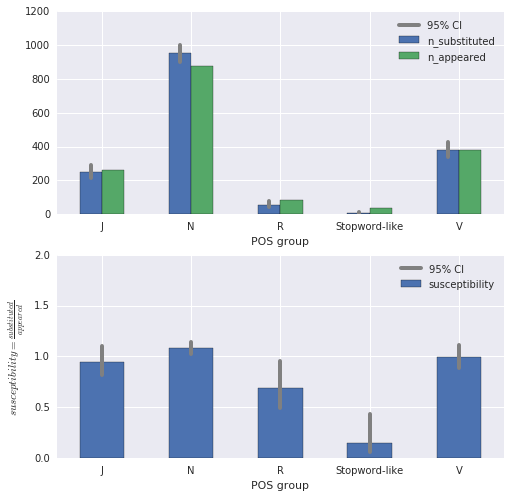

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


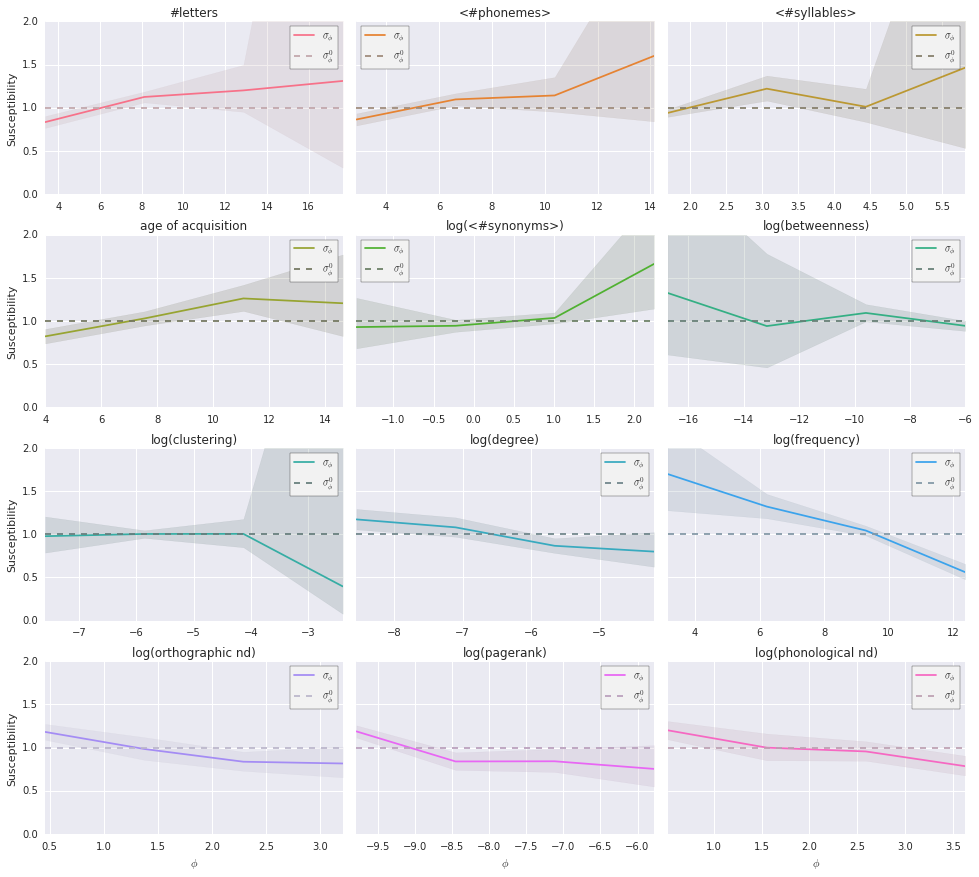

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


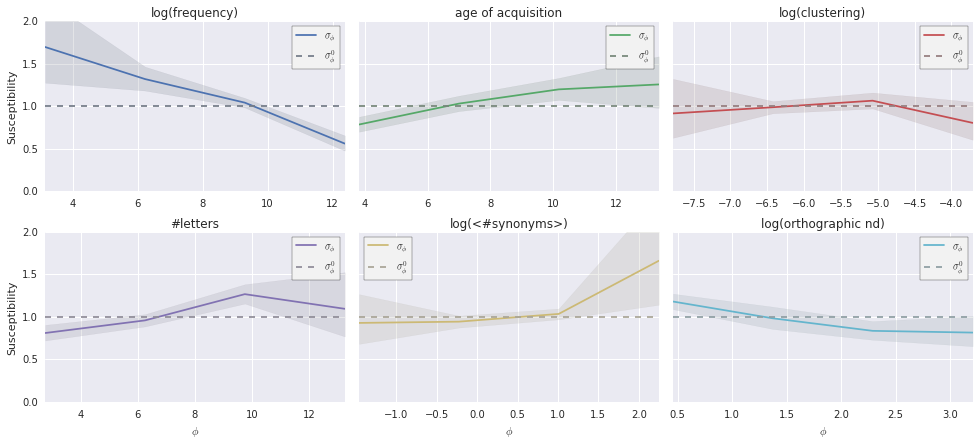

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


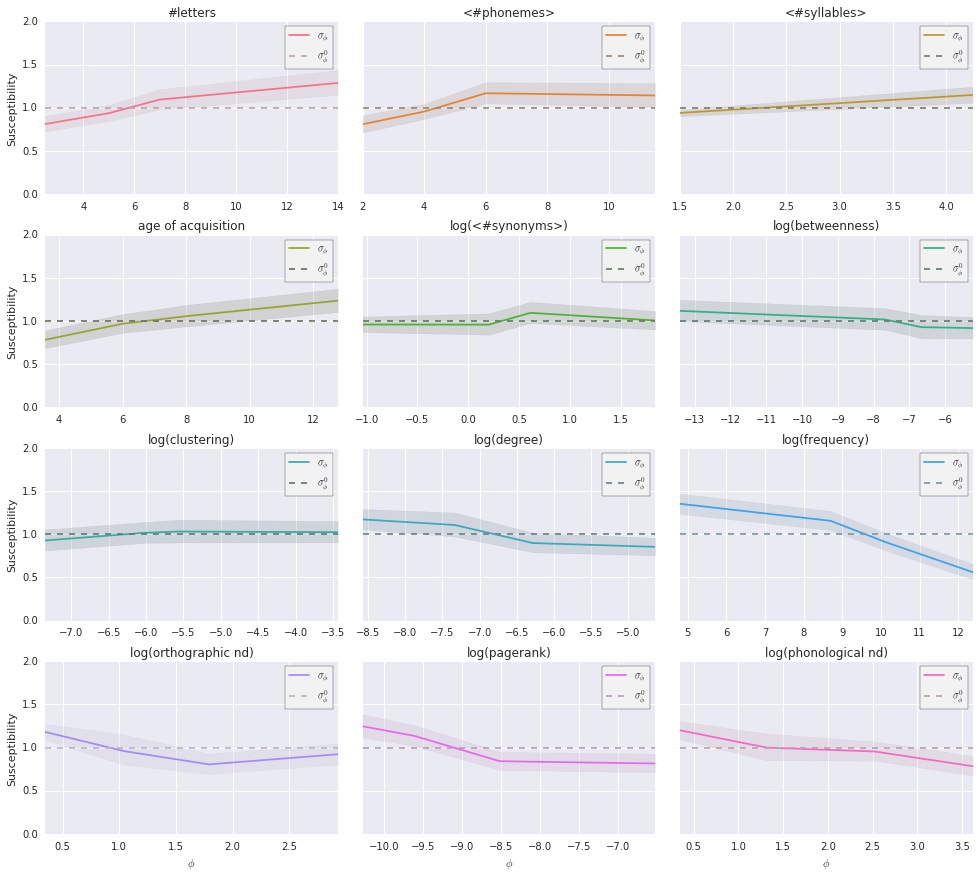

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


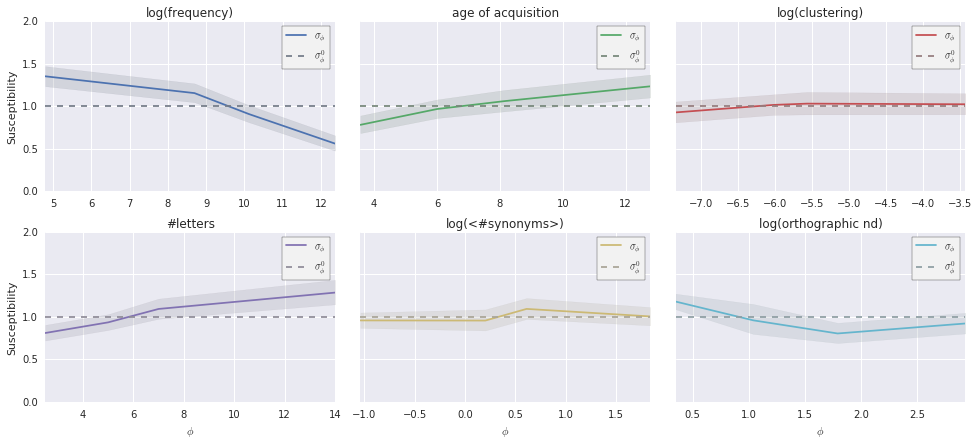

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
     Target NOT different from H_0 (p > 0.001)



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]


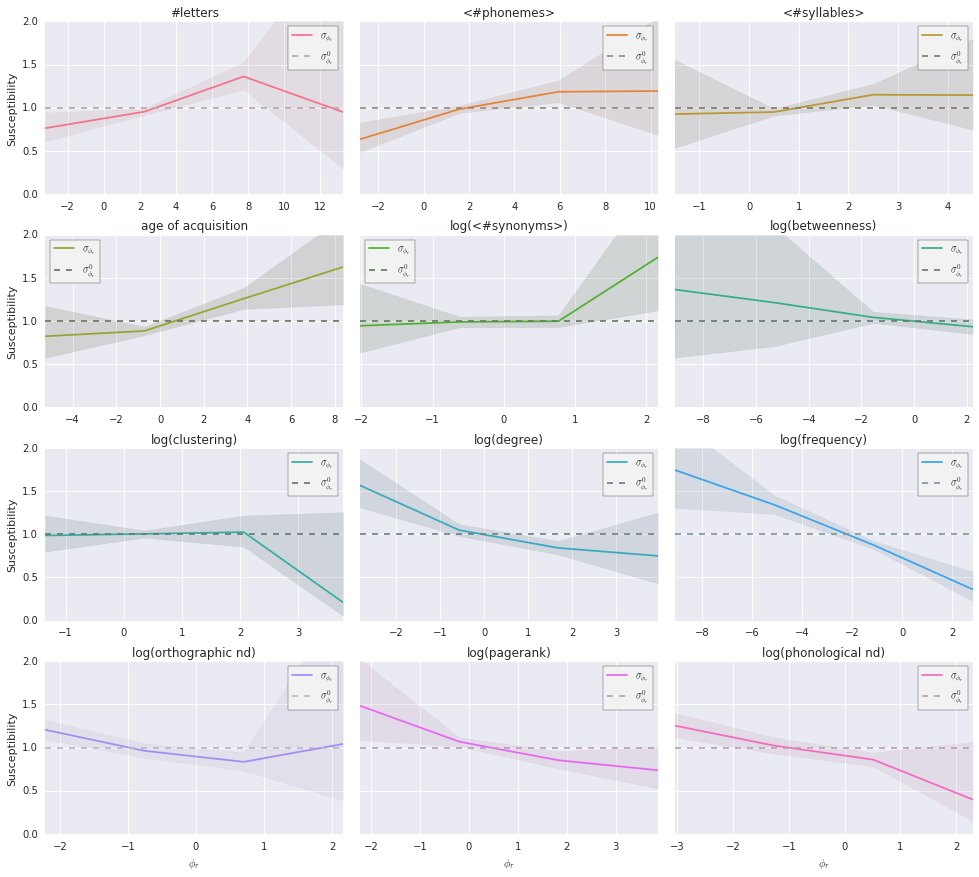

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


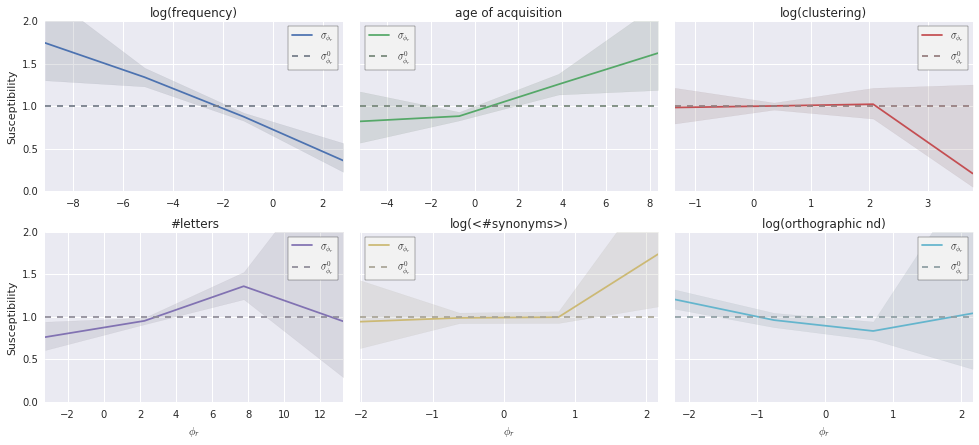

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


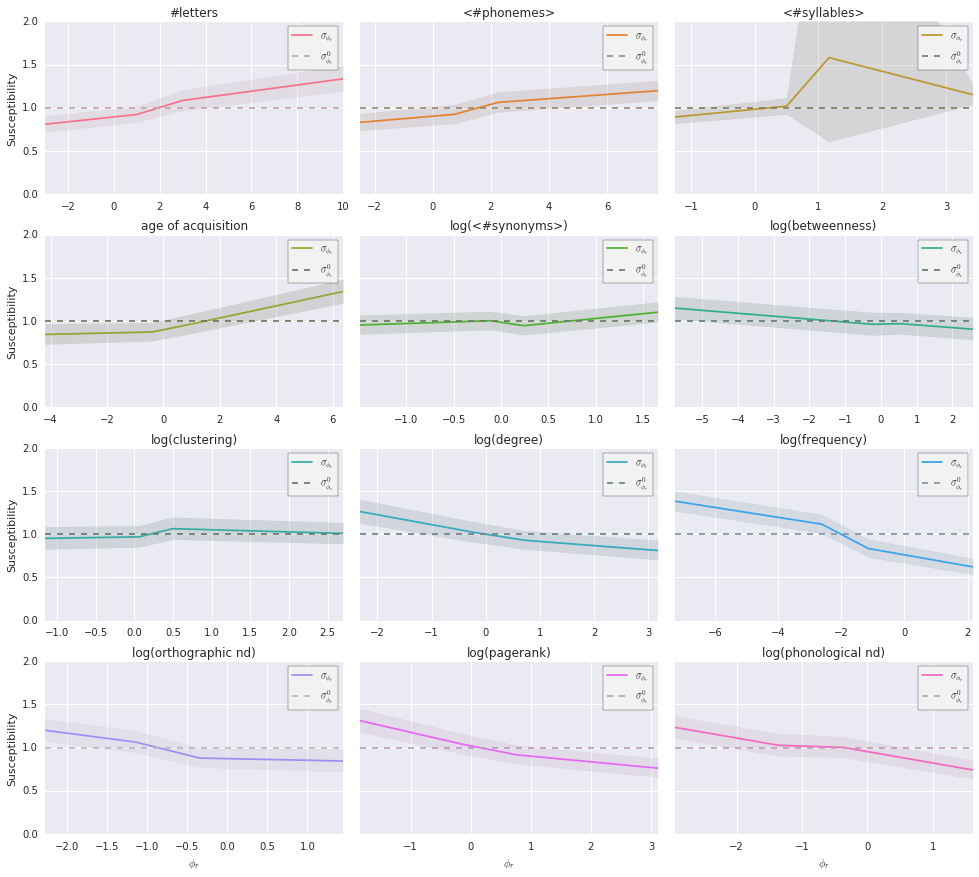

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]


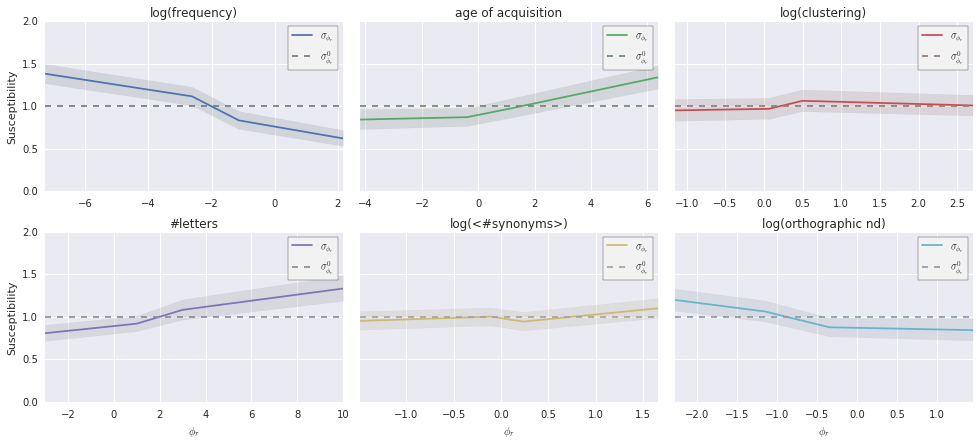

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


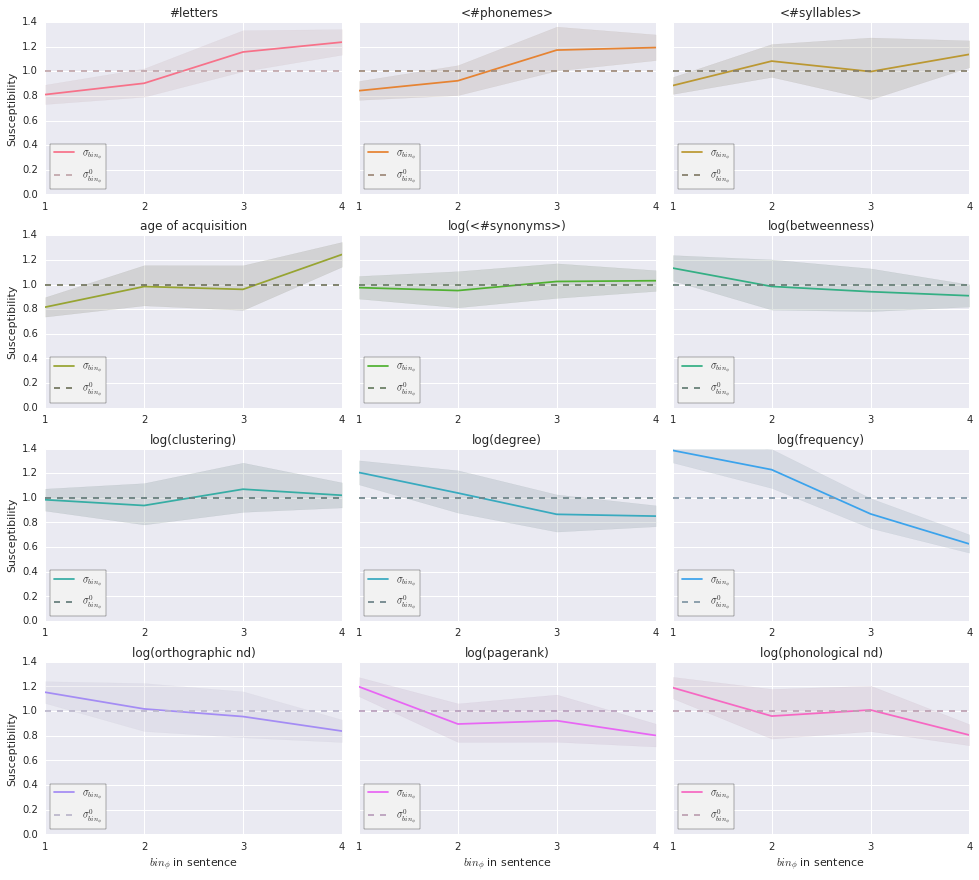

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


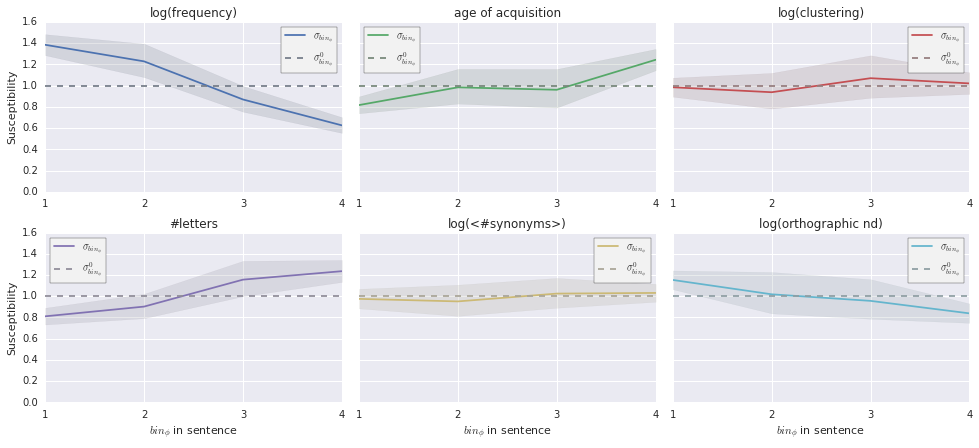

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


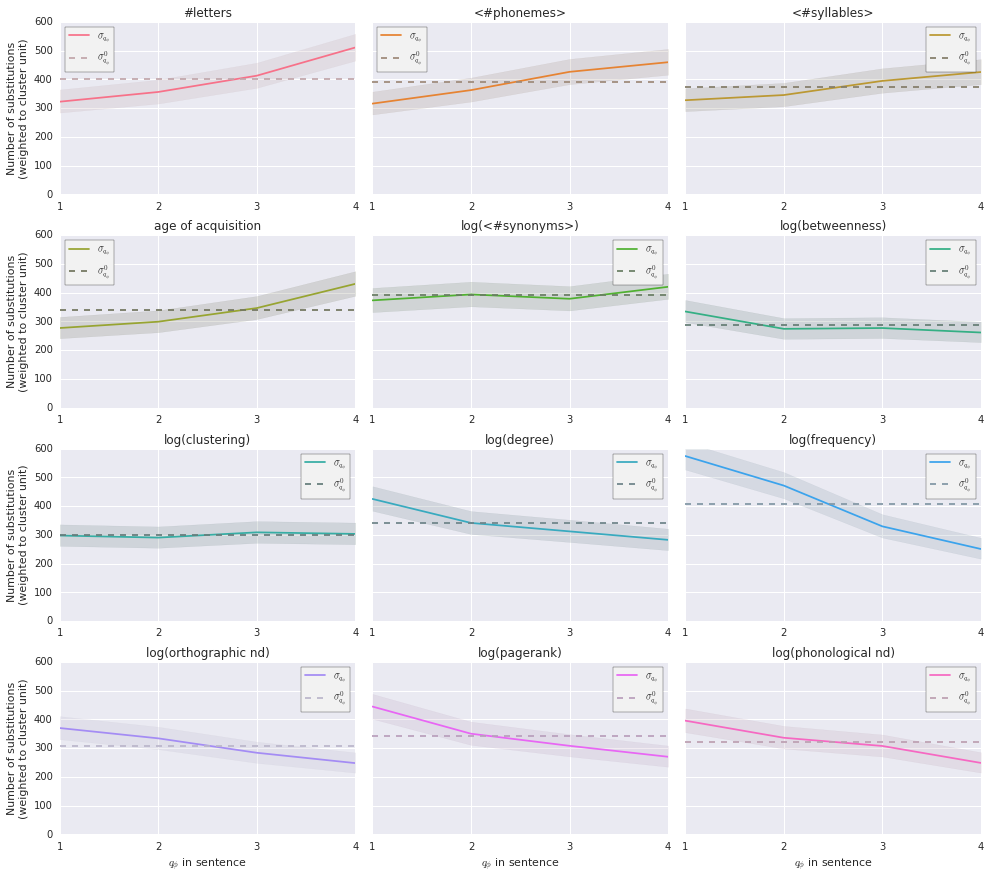

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


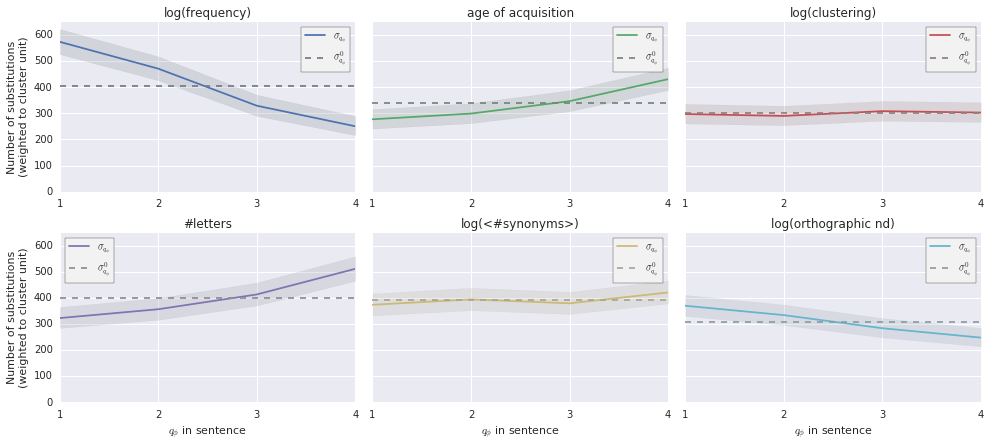

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 176294 word measures (divided into training and prediction sets)


60.30% of words well predicted (non-random at p = 1e-323)
Precision = 0.32
Recall = 0.64

Coefficients:
intercept                                            -0.422362
global_frequency                                     -0.104886
global_aoa                                            0.117685
global_letters_count                                  0.276451
global_orthographic_density                           0.049026
global_frequency * global_aoa                         0.013181
global_frequency * global_letters_count              -0.025042
global_frequency * global_orthographic_density       -0.003332
global_aoa * global_letters_count                    -0.016716
global_aoa * global_orthographic_density             -0.055654
global_letters_count * global_orthographic_density    0.100367
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 176294 word measures (divided into training and prediction sets)



58.99% of words well predicted (non-random at p = 1e-323)
Precision = 0.28
Recall = 0.50

Coefficients:
intercept                                                        -0.375158
sentence-rel_frequency                                           -0.156309
sentence-rel_aoa                                                 -0.054684
sentence-rel_letters_count                                        0.131958
sentence-rel_orthographic_density                                 0.042887
sentence-rel_frequency * sentence-rel_aoa                        -0.005670
sentence-rel_frequency * sentence-rel_letters_count               0.022018
sentence-rel_frequency * sentence-rel_orthographic_density        0.057852
sentence-rel_aoa * sentence-rel_letters_count                     0.030418
sentence-rel_aoa * sentence-rel_orthographic_density              0.005382
sentence-rel_letters_count * sentence-rel_orthographic_density    0.080240
dtype: float64


**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 176294 word measures (divided into training and prediction sets)



62.45% of words well predicted (non-random at p = 1e-323)
Precision = 0.32
Recall = 0.60

Coefficients:


intercept                                                         -8.050311
global_frequency                                                   0.836611
global_aoa                                                        -0.137418
global_letters_count                                               1.108519
global_orthographic_density                                        0.835455
sentence-rel_frequency                                            -0.959971
sentence-rel_aoa                                                  -0.294170
sentence-rel_letters_count                                         0.678924
sentence-rel_orthographic_density                                  0.613784
global_frequency * global_aoa                                      0.014774
global_frequency * global_letters_count                           -0.133826
global_frequency * global_orthographic_density                    -0.139766
global_frequency * sentence-rel_frequency                          0.022798
global_frequ

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 176294 word measures (divided into training and prediction sets)



48.39% of words well predicted (non-random at p = 1e-21)
Precision = 0.28
Recall = 0.81

Coefficients:


intercept                                                       0.272590
bins-global_frequency                                           2.320855
bins-global_aoa                                                -0.266903
bins-global_letters_count                                      -1.983908
bins-global_orthographic_density                                0.219721
bins-global_frequency * bins-global_aoa                        -0.499147
bins-global_frequency * bins-global_letters_count              -0.416463
bins-global_frequency * bins-global_orthographic_density       -0.545192
bins-global_aoa * bins-global_letters_count                     0.789490
bins-global_aoa * bins-global_orthographic_density              0.204374
bins-global_letters_count * bins-global_orthographic_density    0.289531
dtype: float64


**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 176294 word measures (divided into training and prediction sets)



63.84% of words well predicted (non-random at p = 1e-323)
Precision = 0.25
Recall = 0.30

Coefficients:
intercept                                                                 0.822685
quantiles-global_frequency                                               -2.343556
quantiles-global_aoa                                                     -0.319647
quantiles-global_letters_count                                            5.186439
quantiles-global_orthographic_density                                    -3.502943
quantiles-global_frequency * quantiles-global_aoa                         0.941617
quantiles-global_frequency * quantiles-global_letters_count              -1.092465
quantiles-global_frequency * quantiles-global_orthographic_density        1.403063
quantiles-global_aoa * quantiles-global_letters_count                    -0.786728
quantiles-global_aoa * quantiles-global_orthographic_density             -0.343091
quantiles-global_letters_count * quantiles-global_orthographic_de

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 176294 word measures (divided into training and prediction sets)



60.98% of words well predicted (non-random at p = 1e-323)
Precision = 0.28
Recall = 0.45

Coefficients:
intercept                                                                   0.457600
bins-sentence-rel_frequency                                                -0.551246
bins-sentence-rel_aoa                                                       0.227514
bins-sentence-rel_letters_count                                            -0.331297
bins-sentence-rel_orthographic_density                                      0.457600
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.682448
bins-sentence-rel_frequency * bins-sentence-rel_letters_count               0.826374
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.551246
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     0.083605
bins-sentence-rel_aoa * bins-sentence-rel_orthographic_density              0.227514
bins-sentence-rel_letters_count * bins-senten

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 176294 word measures (divided into training and prediction sets)



55.46% of words well predicted (non-random at p = 6e-231)
Precision = 0.29
Recall = 0.66

Coefficients:
intercept                                                                             0.380000
quantiles-sentence-rel_frequency                                                     -0.395637
quantiles-sentence-rel_aoa                                                           -0.071312
quantiles-sentence-rel_letters_count                                                 -0.151513
quantiles-sentence-rel_orthographic_density                                          -0.218602
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.081760
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.028525
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        0.158516
quantiles-sentence-rel_aoa * quantiles-sentence-rel_letters_count                     0.061723
quantiles-sentence-rel_aoa * quantiles-s

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 176294 word measures (divided into training and prediction sets)



65.42% of words well predicted (non-random at p = 1e-323)
Precision = 0.34
Recall = 0.57

Coefficients:
intercept                                                                -0.096108
in-sentence-bins_frequency                                               -0.242372
in-sentence-bins_aoa                                                      0.275448
in-sentence-bins_letters_count                                            0.003874
in-sentence-bins_orthographic_density                                     0.058365
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.049972
in-sentence-bins_frequency * in-sentence-bins_letters_count               0.001506
in-sentence-bins_frequency * in-sentence-bins_orthographic_density        0.058052
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.000278
in-sentence-bins_aoa * in-sentence-bins_orthographic_density             -0.032017
in-sentence-bins_letters_count * in-sentence-bins_orthographic_de

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 1337 aggregated word measures



Variance explained by first 2 components (mle-estimated): [ 0.67785845  0.19349142]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.370213  0.489826
aoa            0.736569 -0.362965
letters_count  0.566046  0.792671


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 1337 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.63279844  0.20898717]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.486853  0.427185
aoa            0.675145 -0.369396
letters_count  0.554214  0.825263
